# **INFO284 Machine Learning Exam, spring 2025**


# **Task 1 - Sentiment analysis**

## **Importing libraries**

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import re
import string

from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
from nltk import pos_tag
from nltk.tokenize import word_tokenize

from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, RandomizedSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline
from sklearn.naive_bayes import MultinomialNB, ComplementNB
from sklearn.metrics import (
    classification_report, confusion_matrix, 
    precision_recall_curve, average_precision_score, roc_auc_score
)

import mglearn
import joblib
import os

from lightgbm import LGBMClassifier

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Embedding, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.metrics import AUC
from sklearn.utils import class_weight

import keras 
from keras.layers import BatchNormalization

2025-04-23 10:59:43.736584: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


## **Helper functions**

### **Heatmap visualization**

In [ ]:
# Helper function to plot heatmap for grid search results
def plot_gridsearch_heatmap(grid, x_param, y_param, score_metric, cmap='viridis'):
    # Convert cv_results_ to a DataFrame
    results = pd.DataFrame(grid.cv_results_)
    
    # Extract the param names from the dict if they have 'param_' prefix
    results['x'] = results[f'param_{x_param}']
    results['y'] = results[f'param_{y_param}']
    results['score'] = results[score_metric]
    
    # Create a pivot table for heatmap
    pivot = results.pivot(index='y', columns='x', values='score')
    
    # Plot heatmap
    plt.figure(figsize=(10, 6))
    sns.heatmap(pivot, annot=True, fmt=".3f", cmap=cmap)

    plt.xlabel(x_param.split('__')[-1])
    plt.ylabel(y_param.split('__')[-1])
    plt.title(f"Heatmap of GridSearch {score_metric}")
    plt.show()

### **Precision-Recall curve**

In [ ]:
# Helper function to plot precision-recall curve
def plot_precision_recall_curve(y_test, y_scores, sentiment):
    precision, recall, _ = precision_recall_curve(y_test, y_scores)
    ap_score = average_precision_score(y_test, y_scores)
    
    plt.figure(figsize=(8, 6))
    plt.plot(recall, precision, marker='.', label=f'AP Score = {ap_score:.2f}')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title(f'Precision-Recall Curve for {sentiment} sentiment')
    plt.legend()
    plt.show()

### **Top features visualization**

In [4]:
# Helper function for visualizing the top features that are most indicative of positive and negative sentiment of reviews
def visualize_top_features(grid, X_train, classifier_step, vectorizer_step="tfidfvectorizer", n_features=20, n_top_coef=40):
    
    # Extract the best vectorizer and transform training data
    vectorizer = grid.best_estimator_.named_steps[vectorizer_step]
    X_train_transformed = vectorizer.transform(X_train)

    # Compute max TF-IDF value for each feature
    max_value = X_train_transformed.max(axis=0).toarray().ravel()
    sorted_by_tfidf = max_value.argsort()

    # Get feature names
    feature_names = np.array(vectorizer.get_feature_names_out())

    # Extract log probabilities from the classifier
    classifier = grid.best_estimator_.named_steps[classifier_step]
    log_probabilities = classifier.feature_log_prob_

    # Compute coefficient differences (importance per class)
    coef_diff = log_probabilities[1] - log_probabilities[0]

    # Visualize the top coefficients
    mglearn.tools.visualize_coefficients(coef_diff, feature_names, n_top_features=n_top_coef)

## **Load data**

In [5]:
df = pd.read_csv('dataset/Hotel_Reviews.csv')
# Creating a copy of the dataframe to preserve the original data for visualization 
df_copy = pd.read_csv('dataset/Hotel_Reviews.csv')

df.head()

,Hotel_Address,Additional_Number_of_Scoring,Review_Date,Average_Score,Hotel_Name,Reviewer_Nationality,Negative_Review,Review_Total_Negative_Word_Counts,Total_Number_of_Reviews,Positive_Review,Review_Total_Positive_Word_Counts,Total_Number_of_Reviews_Reviewer_Has_Given,Reviewer_Score,Tags,days_since_review,lat,lng
0,s Gravesandestraat 55 Oost 1092 AA Amsterdam ...,194,8/3/2017,7.7,Hotel Arena,Russia,I am so angry that i made this post available...,397,1403,Only the park outside of the hotel was beauti...,11,7,2.9,"[' Leisure trip ', ' Couple ', ' Duplex Double...",0 days,52.360576,4.915968
1,s Gravesandestraat 55 Oost 1092 AA Amsterdam ...,194,8/3/2017,7.7,Hotel Arena,Ireland,No Negative,0,1403,No real complaints the hotel was great great ...,105,7,7.5,"[' Leisure trip ', ' Couple ', ' Duplex Double...",0 days,52.360576,4.915968
2,s Gravesandestraat 55 Oost 1092 AA Amsterdam ...,194,7/31/2017,7.7,Hotel Arena,Australia,Rooms are nice but for elderly a bit difficul...,42,1403,Location was good and staff were ok It is cut...,21,9,7.1,"[' Leisure trip ', ' Family with young childre...",3 days,52.360576,4.915968
3,s Gravesandestraat 55 Oost 1092 AA Amsterdam ...,194,7/31/2017,7.7,Hotel Arena,United Kingdom,My room was dirty and I was afraid to walk ba...,210,1403,Great location in nice surroundings the bar a...,26,1,3.8,"[' Leisure trip ', ' Solo traveler ', ' Duplex...",3 days,52.360576,4.915968
4,s Gravesandestraat 55 Oost 1092 AA Amsterdam ...,194,7/24/2017,7.7,Hotel Arena,New Zealand,You When I booked with your company on line y...,140,1403,Amazing location and building Romantic setting,8,3,6.7,"[' Leisure trip ', ' Couple ', ' Suite ', ' St...",10 days,52.360576,4.915968


## **Exploring the dataset**

### **Basic structure**

In [ ]:
# Lets explore the basic structure of the dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515738 entries, 0 to 515737
Data columns (total 17 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   Hotel_Address                               515738 non-null  object 
 1   Additional_Number_of_Scoring                515738 non-null  int64  
 2   Review_Date                                 515738 non-null  object 
 3   Average_Score                               515738 non-null  float64
 4   Hotel_Name                                  515738 non-null  object 
 5   Reviewer_Nationality                        515738 non-null  object 
 6   Negative_Review                             515738 non-null  object 
 7   Review_Total_Negative_Word_Counts           515738 non-null  int64  
 8   Total_Number_of_Reviews                     515738 non-null  int64  
 9   Positive_Review                             515738 non-null  object 
 

There are some missing values in the columns "lat" and "lng" where non-null count is 512,470 out of 515,738. 

We interpret the column Reviewer_Score as the most suitable label for sentiment analysis, because it's a numerical value that can be used to classify the sentiment of the review as positive or negative, assuming higher score indicates more positive sentiment, and vice versa. 

In [7]:
df[df['lat'].isna()].head(10)

,Hotel_Address,Additional_Number_of_Scoring,Review_Date,Average_Score,Hotel_Name,Reviewer_Nationality,Negative_Review,Review_Total_Negative_Word_Counts,Total_Number_of_Reviews,Positive_Review,Review_Total_Positive_Word_Counts,Total_Number_of_Reviews_Reviewer_Has_Given,Reviewer_Score,Tags,days_since_review,lat,lng
99488,20 Rue De La Ga t 14th arr 75014 Paris France,22,8/3/2017,7.8,Mercure Paris Gare Montparnasse,Australia,No Negative,0,377,Upgraded rooms are excellent Good size for tr...,25,6,10.0,"[' Leisure trip ', ' Couple ', ' Standard Room...",0 days,NaN,NaN
99489,20 Rue De La Ga t 14th arr 75014 Paris France,22,8/3/2017,7.8,Mercure Paris Gare Montparnasse,United Kingdom,Noise Not being told about this when we check...,12,377,The location was great However renovations we...,45,1,6.7,"[' Leisure trip ', ' Couple ', ' Standard Room...",0 days,NaN,NaN
99490,20 Rue De La Ga t 14th arr 75014 Paris France,22,7/25/2017,7.8,Mercure Paris Gare Montparnasse,United States of America,Room was worn down One of the curtains did no...,43,377,Location was good,5,1,5.4,"[' Leisure trip ', ' Solo traveler ', ' Standa...",9 days,NaN,NaN
99491,20 Rue De La Ga t 14th arr 75014 Paris France,22,6/22/2017,7.8,Mercure Paris Gare Montparnasse,Australia,Access to shower was by the tub which is very...,54,377,No Positive,0,13,8.3,"[' Leisure trip ', ' Couple ', ' Standard Twin...",42 days,NaN,NaN
99492,20 Rue De La Ga t 14th arr 75014 Paris France,22,5/24/2017,7.8,Mercure Paris Gare Montparnasse,United States of America,The breakfast was way over priced and the sta...,83,377,The property was conveniently located near th...,11,2,5.8,"[' Leisure trip ', ' Couple ', ' Standard Room...",71 days,NaN,NaN
99493,20 Rue De La Ga t 14th arr 75014 Paris France,22,5/5/2017,7.8,Mercure Paris Gare Montparnasse,Belgium,Work in progress noise no bar keys had to be ...,39,377,Comfort,2,3,5.0,"[' Leisure trip ', ' Family with young childre...",90 days,NaN,NaN
99494,20 Rue De La Ga t 14th arr 75014 Paris France,22,2/11/2017,7.8,Mercure Paris Gare Montparnasse,United Kingdom,Max price for the bare minimum Acor Hotels ca...,67,377,Few minutes walk to Ga t Metro Montparnasse M...,46,20,5.8,"[' Business trip ', ' Couple ', ' Standard Roo...",173 day,NaN,NaN
99495,20 Rue De La Ga t 14th arr 75014 Paris France,22,12/5/2016,7.8,Mercure Paris Gare Montparnasse,United Kingdom,Ongoing refurbishment whilst we were there,8,377,Very quiet at night couldn t believe we were ...,21,1,8.8,"[' Leisure trip ', ' Couple ', ' Standard Room...",241 day,NaN,NaN
99496,20 Rue De La Ga t 14th arr 75014 Paris France,22,10/30/2016,7.8,Mercure Paris Gare Montparnasse,France,We took a room for 3 the extra bed couch bed ...,23,377,Great location 5 min away from gare montparna...,32,34,8.3,"[' Leisure trip ', ' Family with young childre...",277 day,NaN,NaN
99497,20 Rue De La Ga t 14th arr 75014 Paris France,22,10/11/2016,7.8,Mercure Paris Gare Montparnasse,United States of America,N A Room lacking microwave a minor inconvenie...,10,377,Great neighborhood with lots of restaurants s...,22,1,10.0,"[' Leisure trip ', ' Couple ', ' Standard Room...",296 day,NaN,NaN


We check the first 10 rows containing NaN values in lat column, to check for any discrepancies in the data. As nothing stands out as strange in the reviews with missing values in lat column, we do nothing.

### **Review scores distribution** 

In [ ]:
# Show a statistical summary of the target column in the dataset: Reviewer_Score.
print(df['Reviewer_Score'].describe()) 

count    515738.000000
mean          8.395077
std           1.637856
min           2.500000
25%           7.500000
50%           8.800000
75%           9.600000
max          10.000000
Name: Reviewer_Score, dtype: float64


**Insights:**
* min = 2.5 and max = 10.0.
* mean = 8.4 - average reviewer score, suggesting that most reviews have a high score.
* std = 1.6 - reviewer scores are fairly consistent and do not vary significantly, but are close to average score.
* 25th percentile (Q1) = 7.5 → 25% of the reviews have a score below 7.5, meaning that the majority (75%) have a score above 7.5. This suggests that most of the scores are relatively high. The 50th & 75th percentiles are also high, reinforcing this idea.

**Takeaway:**
* Distribution is skewed towards high scores, suggesting that the dataset is imbalanced, which is something we need to consider when building models. This does not surprise us as we expect most hotel reviews to be positive, as otherwise the hotel would not likely be in business.

<Axes: >

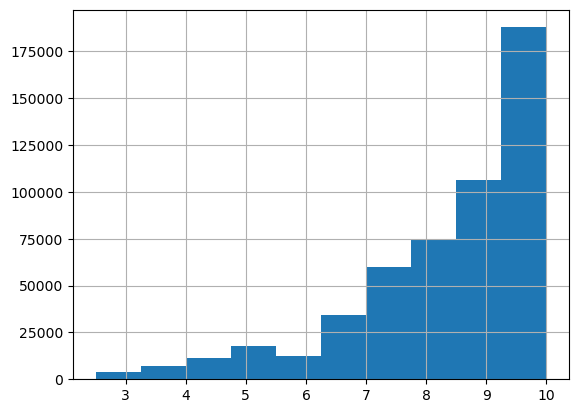

In [9]:
# Histogram showing the distribution of the review scores 
df['Reviewer_Score'].hist(bins=10)

In [10]:
# Show the distribution of the review scores in bins
print(df['Reviewer_Score'].value_counts(bins=10))

(9.25, 10.0]     187807
(8.5, 9.25]      105659
(7.75, 8.5]       75277
(7.0, 7.75]       59733
(6.25, 7.0]       34502
(4.75, 5.5]       18175
(5.5, 6.25]       12304
(4.0, 4.75]       11469
(3.25, 4.0]        6979
(2.491, 3.25]      3833
Name: count, dtype: int64


- Histogram: shows what we already know from statistical summary. The dataset is heavily imbalanced. 

After understanding some basic information about the dataset, we move on to preprocessing the data.

## **Cleaning review texts and finding threshold**

- Columns "Negative_Review" and "Positive_Review" contain the review text.
- Many entries are just placeholders like "No Negative" or "No Positive".
- These placeholders are irrelevant for sentiment analysis.
- We will replace them with empty strings to avoid misleading the model.
- This prepares the data for merging both review columns into one.

#### **Attempt to find a limit for positive and negative reviews**
- Before removing the placeholders, we try to extract useful insights from them.
- We analyze the distribution of review scores where "No Positive" or "No Negative" appears.
- Goal: Identify a threshold to separate positive and negative sentiment scores.

In [13]:
# Here we check the mean and median scores of reviews that are blank, e.g. they contain both strings "No Negative" and "No Positive" in the columns "Negative_Review" and "Positive_Review" respectively.
none_mean = df[(df['Negative_Review'] == 'No Negative') & (df['Positive_Review'] == 'No Positive')]['Reviewer_Score'].mean()
none_median = df[(df['Negative_Review'] == 'No Negative') & (df['Positive_Review'] == 'No Positive')]['Reviewer_Score'].median()

# We also see how many reviews are blank 
amount_none = df[(df['Negative_Review'] == 'No Negative') & (df['Positive_Review'] == 'No Positive')].shape[0]

# Here we check the mean and median scores of reviews that are positive, i.e. they contain the string "No Negative" in the column "Negative_Review" and do not contain the string "No Positive" in the column "Positive_Review".
positive_mean = df[(df['Negative_Review'] == 'No Negative') & (df['Positive_Review'] != 'No Positive')]['Reviewer_Score'].mean()
positive_median = df[(df['Negative_Review'] == 'No Negative') & (df['Positive_Review'] != 'No Positive')]['Reviewer_Score'].median()

# Here we check the mean and median scores of reviews that are negative, i.e. they contain the string "No Positive" in the column "Positive_Review" and do not contain the string "No Negative" in the column "Negative_Review".
negative_mean = df[(df['Negative_Review'] != 'No Negative') & (df['Positive_Review'] == 'No Positive')]['Reviewer_Score'].mean()
negative_median = df[(df['Negative_Review'] != 'No Negative') & (df['Positive_Review'] == 'No Positive')]['Reviewer_Score'].median()

print('Mean of no negative and no positive (blank reviews):', none_mean)
print('Median of no negative and no positive (blank reviews):', none_median)
print('Amount of reviews with no negative and no positive (blank reviews):', amount_none)
print()
print('Mean of positive reviews:', positive_mean)
print('Median of positive reviews:', positive_median)
print()
print('Mean of negative reviews:', negative_mean)
print('Median of negative reviews:', negative_median)

Mean of no negative and no positive (blank reviews): 8.285826771653543
Median of no negative and no positive (blank reviews): 8.8
Amount of reviews with no negative and no positive (blank reviews): 127

Mean of positive reviews: 9.339492654367852
Median of positive reviews: 9.6

Mean of negative reviews: 6.881705240235629
Median of negative reviews: 7.1


In [12]:
# Here we calculate the percentage of reviews that contain 'No Negative' in the 'Negative_Review' column and 'No Positive' in the 'Positive_Review' column
def percentage_of_reviews():
    no_negative = df[df['Negative_Review'] == 'No Negative'].shape[0]
    no_positive = df[df['Positive_Review'] == 'No Positive'].shape[0]
    total = df.shape[0]

    positive_percentage = no_negative / total * 100
    negative_percentage = no_positive / total * 100

    print('Percentage of clearly positive reviews:', positive_percentage)
    print('Percentage of clearly negative reviews:', negative_percentage)

percentage_of_reviews()

Percentage of clearly positive reviews: 24.797474686759557
Percentage of clearly negative reviews: 6.96981800836859


- 127 reviews only contain "No Negative" and "No Positive" — essentially blank.
    - Mean score ≈ 8.3, median 8.8 → strongly positive sentiment.
    - These reviews are removed later, as they’re useless for sentiment analysis.
- 24.7% of reviews contain "No Negative":
    - Mean score ≈ 9.3, median 9.6 → extremely positive.
- 7% of reviews contain "No Positive":
    - Mean score ≈ 6.9, median 7.1 → relatively lower sentiment.
- Insight: Sentiment threshold might need to be set high, possibly around 7.

We can plot the relationship between score and word count of each sentiment, to further investigate a potential threshold for separating the reviews.

/var/folders/gk/fhc5s9xs7pzck55c8_420hg40000gn/T/ipykernel_78061/1613613854.py:11: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = df.groupby('bin').agg(
/var/folders/gk/fhc5s9xs7pzck55c8_420hg40000gn/T/ipykernel_78061/1613613854.py:11: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = df.groupby('bin').agg(


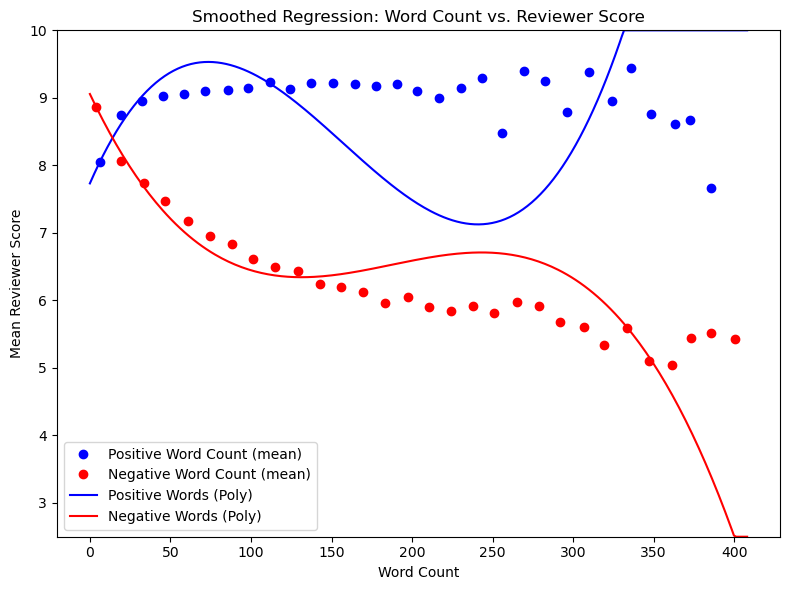

Intersection point: x = 14.10, y = 8.41


In [ ]:
def compute_means(df, col, bins=30):
    """Bins data and computes the mean Reviewer Score per bin."""
    df['bin'] = pd.cut(df[col], bins=bins)
    grouped = df.groupby('bin').agg(
        mean_count=(col, 'mean'),
        mean_score=('Reviewer_Score', 'mean')
    ).dropna()
    return grouped[['mean_count', 'mean_score']]

def find_intersection_non_linear(df, degree=2):
    """Find intersection point of two polynomial regression curves."""
    X_pos = df[['pos_count']].values
    X_neg = df[['neg_count']].values
    y = df['Reviewer_Score'].values

    poly = PolynomialFeatures(degree)
    X_pos_poly = poly.fit_transform(X_pos)
    X_neg_poly = poly.fit_transform(X_neg)

    model_pos = LinearRegression().fit(X_pos_poly, y)
    model_neg = LinearRegression().fit(X_neg_poly, y)

    # Coefficients
    coeffs_pos = model_pos.coef_
    coeffs_neg = model_neg.coef_

    # Solve: a1*x^2 + b1*x + c1 = a2*x^2 + b2*x + c2
    a = coeffs_pos[2] - coeffs_neg[2]
    b = coeffs_pos[1] - coeffs_neg[1]
    c = model_pos.intercept_ - model_neg.intercept_

    discriminant = b**2 - 4*a*c

    if discriminant >= 0:
        x1 = (-b + np.sqrt(discriminant)) / (2*a)
        x2 = (-b - np.sqrt(discriminant)) / (2*a)
        x_int = x1 if x1 >= 0 else x2
        y_int = model_pos.predict(poly.transform([[x_int]]))[0]
        return x_int, y_int
    else:
        return None

def plot_sentiment_vs_score_clean(df, degree=2, bins=30):
    """Clean smoothed plots with means and polynomial regression curves, clipped to [2.5, 10]."""
    df[['pos_count', 'neg_count']] = df[['Review_Total_Positive_Word_Counts', 'Review_Total_Negative_Word_Counts']]

    pos_means = compute_means(df, 'pos_count', bins)
    neg_means = compute_means(df, 'neg_count', bins)

    poly = PolynomialFeatures(degree)

    X_pos = df[['pos_count']].values
    X_neg = df[['neg_count']].values
    y = df['Reviewer_Score'].values

    X_pos_poly = poly.fit_transform(X_pos)
    X_neg_poly = poly.fit_transform(X_neg)

    model_pos = LinearRegression().fit(X_pos_poly, y)
    model_neg = LinearRegression().fit(X_neg_poly, y)

    x_range = np.linspace(0, max(df[['pos_count', 'neg_count']].max()), 300).reshape(-1, 1)
    y_pos_pred = model_pos.predict(poly.transform(x_range))
    y_neg_pred = model_neg.predict(poly.transform(x_range))

    # Clip predictions between 2.5 and 10
    y_pos_pred = np.clip(y_pos_pred, 2.5, 10)
    y_neg_pred = np.clip(y_neg_pred, 2.5, 10)

    plt.figure(figsize=(8, 6))

    # Smoothed mean points
    plt.plot(pos_means['mean_count'], pos_means['mean_score'], 'o', color='blue', label='Positive Word Count (mean)')
    plt.plot(neg_means['mean_count'], neg_means['mean_score'], 'o', color='red', label='Negative Word Count (mean)')

    # Fitted regression curves
    plt.plot(x_range, y_pos_pred, color='blue', label="Positive Words (Poly)")
    plt.plot(x_range, y_neg_pred, color='red', label="Negative Words (Poly)")

    plt.title("Smoothed Regression: Word Count vs. Reviewer Score")
    plt.xlabel("Word Count")
    plt.ylabel("Mean Reviewer Score")
    plt.ylim(2.5, 10)  # Lock y-axis range
    plt.legend()
    plt.tight_layout()
    plt.show()

    # Print intersection info separately
    intersection = find_intersection_non_linear(df, degree)
    if intersection:
        x_int, y_int = intersection
        print(f"Intersection point: x = {x_int:.2f}, y = {y_int:.2f}")
    else:
        print("No intersection point found.")

plot_sentiment_vs_score_clean(df, degree=3, bins=30)


**General trend:**
- More positive words -> Steady increase in score.
- More negative words -> Steeper reduction in score.
- Negative word count has larger impact on score than positive word count. Some sort of negativity bias?
- Intersection point at 8.4.

Let's see how distribution of reviews would look like with split at 8,4.

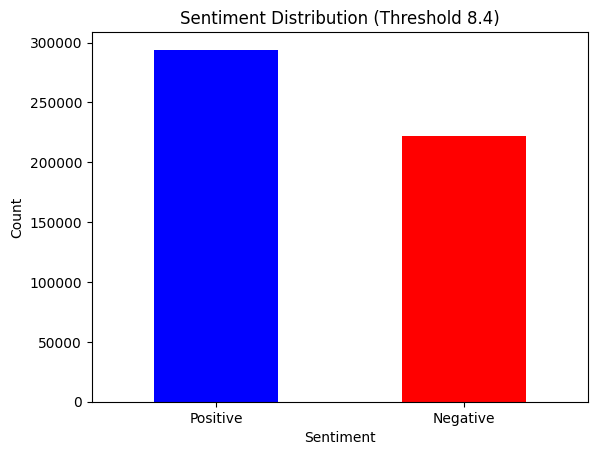

In [20]:
df_copy['Sentiment'] = df_copy['Reviewer_Score'].apply(lambda x: 'Positive' if x > 8.4 else 'Negative')

df_copy['Sentiment'].value_counts().plot(kind='bar', color=['blue', 'red'])
plt.title('Sentiment Distribution (Threshold 8.4)')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.show()

Let's see distribution at 7.1 (median of reviews with "No Positive").

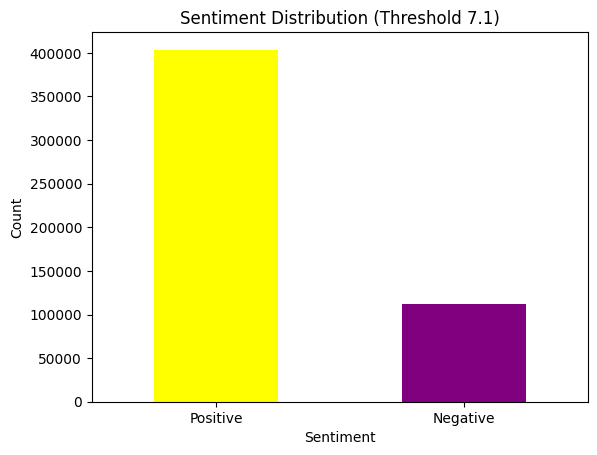

In [21]:
df_copy['Sentiment'] = df_copy['Reviewer_Score'].apply(lambda x: 'Positive' if x > 7.1 else 'Negative')

df_copy['Sentiment'].value_counts().plot(kind='bar', color=['yellow', 'purple'])
plt.title('Sentiment Distribution (Threshold 7.1)')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.show()

**Takeaways:**
- 8.4 -> More balanced distribution -> Seems unrealistic to say that score lower than 8.4 is negative.
- 7.1 -> Extremely imbalanced distribution.
- Dataset should be imbalanced -> 7.1 more accurate to our expectations, but extremely low negative count, bad for model training.
- Threshold is inherently arbitrary. Makes sense to select a value in between the two: 7.8: a reasonable compromise.

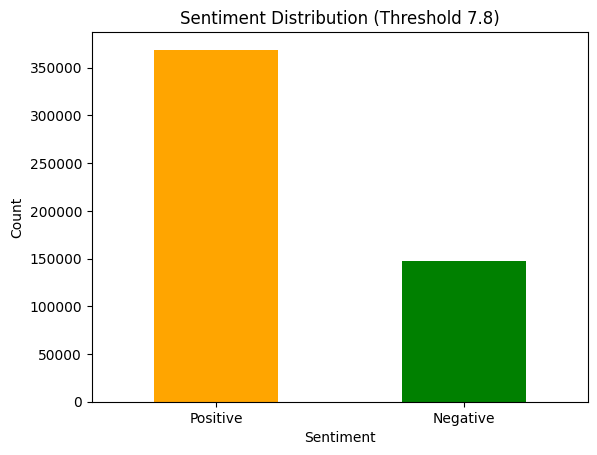

In [22]:
df_copy['Sentiment'] = df_copy['Reviewer_Score'].apply(lambda x: 'Positive' if x > 7.8 else 'Negative')

df_copy['Sentiment'].value_counts().plot(kind='bar', color=['orange', 'green'])
plt.title('Sentiment Distribution (Threshold 7.8)')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.show()

Increase of almost 50,000 negatives. Should be a good enough threshold.

#### **Cleaning blank review columns**

We remove the previously discussed blank reviews.

In [21]:
# Count how many reviews contain the strings "No Negative" and "No Positive" in the columns "Negative_Review" and "Positive_Review" respectively
def count_reviews_with_sentiment_in_text():
    no_negative = 0
    no_positive = 0
    for review in df['Negative_Review']:
        if "No Negative" in review and review != 'No Negative':
            no_negative += 1

    for review in df['Positive_Review']:
        if "No Positive" in review and review != 'No Positive':
                no_positive += 1

    return no_negative, no_positive

print("Reviews containing either 'No Negative' or 'No Positive' in the review itself:")
print(count_reviews_with_sentiment_in_text())

print("Removing reviews with only 'No Negative' and 'No Positive' placeholders ('blank reviews'):")

df['Negative_Review'] = df['Negative_Review'].apply(lambda x: x if x != 'No Negative' else '')
df['Positive_Review'] = df['Positive_Review'].apply(lambda x: x if x != 'No Positive' else '')

# Confirm that the replacements were successful and did not remove occurences of the strings "No Negative" and "No Positive" in ordinary reviews
print(count_reviews_with_sentiment_in_text())
percentage_of_reviews()

df = df[(df['Negative_Review'] != '') | (df['Positive_Review'] != '')]

Reviews containing either 'No Negative' or 'No Positive' in the review itself:
(3, 0)
Removing reviews with only 'No Negative' and 'No Positive' placeholders ('blank reviews'):
(3, 0)
Percentage of clearly positive reviews: 0.0
Percentage of clearly negative reviews: 0.0


- We replace the columns that ONLY contain the placeholders with blank space.
- We check that this operation is successful by checking previously printed percentages. 
- We check the reviews containing "No Negative" in the text.

In [24]:
print("The three reviews containing 'No Negative' and their rating:")
for review in df['Negative_Review']:
    if "No Negative" in review and review != 'No Negative':
        print(review + str(df[df['Negative_Review'] == review]['Reviewer_Score'].values[0]))

The three reviews containing 'No Negative' and their rating:
 No Negative Points Everything great 9.6
 No Negative comments only that we wish we could have stayed there longer And giving it a 10 rating is selling the hotel short in my eyes 10.0
 No Negatives from us only Thumbs Up 10.0


- Extremely positive reviews.
- No need to do anything.

We move on to adressing reviews containing foreign language.

## **Exploring reviews written in foreign languages**

Some of the reviews are written in or contain foreign languages. 
This will be a problem for our models as we base them on the English language, and adressing this may help their performance.

In [ ]:
# We combine the review text columns in the copy of the dataset for easier visualization 
df_copy['Review'] = df_copy['Negative_Review'] + ' ' + df_copy['Positive_Review']

In [26]:
# Here we check the distribution of reviewer nationality.
df_copy['Reviewer_Nationality'].describe()

count               515738
unique                 227
top        United Kingdom 
freq                245246
Name: Reviewer_Nationality, dtype: object

In [27]:
# We then check the top 10 reviewer nationalities. 
print(df_copy['Reviewer_Nationality'].value_counts().head(10))

Reviewer_Nationality
United Kingdom               245246
United States of America      35437
Australia                     21686
Ireland                       14827
United Arab Emirates          10235
Saudi Arabia                   8951
Netherlands                    8772
Switzerland                    8678
Germany                        7941
Canada                         7894
Name: count, dtype: int64


In [28]:
# Furthermore, we decide to check if any reviews contain non-latin alphabet characters.  
def check_non_latin_letters(dataframe):
    count = 0
    for review in dataframe['Review']:
        if review is not None: 
            matches = re.findall(r'[^\x00-\x7F\d\W_]', review)
            for match in matches:
                count += 1
    return count

print("Number of reviews with non-latin alphabetic characters:", check_non_latin_letters(df_copy))

Number of reviews with non-latin alphabetic characters: 0


**Insights:**
- No reviews contain non-latin alphabetic characters.
- The top nationalities almost exclusively use latin alphabet in their official language, exceptions being Saudi Arabia and United Arab Emirates. 
- Therefore, we assume reviews from arabic countries are in English, and inspection of their reviews seem to confirm this.
- No action needed

The initial cause for this inquiry into foreign language reviews was caused by reviews written in swedish. Let's explore them: 

In [29]:
print("Swedish reviews count:")
print(df_copy['Reviewer_Nationality'].value_counts()[' Sweden '])

Swedish reviews count:
3368


In [ ]:
print("Several examples of Swedish reviews:")
print('1.' + df_copy.loc[224965, 'Review'] + '\n')
print('2.' + df_copy.loc[102335, 'Review'] + '\n')
print('3.' + df_copy.loc[514238, 'Review'] + '\n')
print('4.' + df_copy.loc[44876, 'Review'] + '\n')
print('5.' + df_copy.loc[381438, 'Review'] + '\n')

Several examples of Swedish reviews:
1. Rummet var litet Toalett utan handfat Tr ngt badrum D lig frukost utan gr nsaker Liten pool i ett annat hus S sm f rvaringssk p   Bra l ge N ra till Eiffeltornet floden och nya k pcentrum 

2. H rd s ng var enda minus under vistelsen   Utm rkt l ge p hotellet Kort g avst nd fr n tinnelbanan och bussen alldeles utanf r d rren Ett extra plus var att en buss gick direkt till westfield gallerian med shopping i m ngder 

3. Sv rt att f rst och g ra sig f rst dd hos personalen vars engelska ibland var v ldigt bristf llig   J ttegod frukost med stort utbud 

4. S ngarna var f r h rda i min smak Omgivningarna best r av nyare byggnader med m nga kontorshus s det r inte s charmig del av London   Trevlig v lst dat rum i engelsk stil Fint badrum Ett plus att man dagligen fick tv l och tv vatten i kylsk pet gratis Mycket positiv och trevlig personal i matsalen Frukosten var bra eftersom man fick v lja ett varmt alternativ fr n menyn annars hade det blivit lit

- Clearly these reviews are nonsense for our models.

In [31]:
swedish_reviews = df_copy[df_copy['Reviewer_Nationality'] == ' Sweden ']
total_negative_words = swedish_reviews['Review_Total_Negative_Word_Counts'].sum()
total_positive_words = swedish_reviews['Review_Total_Positive_Word_Counts'].sum()

print('Total number of negative words in Swedish reviews:', total_negative_words)
print('Total number of positive words in Swedish reviews:', total_positive_words)

Total number of negative words in Swedish reviews: 72640
Total number of positive words in Swedish reviews: 64246


- Ratio of positive to negative words in the Swedish reviews is almost equal.
- We remove Swedish reviews - solves problem - not huge loss of data.

In [ ]:
# Exclude Swedish reviews from the dataset
df = df[df['Reviewer_Nationality'] != ' Sweden ']

We decide to not explore reviews written by other foreign languages, as results are minimal compared to time spent and by the fact that the majority of the reviews are written by english speakers. We acknowledge however, that cleaning the dataset to only contain reviews written in English would be ideal. 

## **Transforming review scores to binary values**

We add a new column: 'Sentiment' which is 0 (representing negative reviews) if reviewer score is less than or equal to 7,8 and 1 (positive) if score is greater than 7,8.

In [ ]:
df['Sentiment'] = df['Reviewer_Score'].apply(lambda x: 1 if x > 7.8 else 0)

print(df['Sentiment'].value_counts())
print(df['Sentiment'].value_counts(normalize=True) * 100)

Sentiment
1    366397
0    145846
Name: count, dtype: int64
Sentiment
1    71.527966
0    28.472034
Name: proportion, dtype: float64


- The results above again reflect that the dataset is imbalanced: ≈70% of reviews being positive. 
- We keep the original dataset as it is to reflect a real-world distribution, where most reviews are usually positive.
- Balancing the classes (e.g., oversampling negatives) can help detect minority cases but risks introducing artificial patterns.
- Such changes may reduce real-world generalizability.
- The trade-off: models may lean towards predicting positive reviews more often.

## **Preprocessing the review text**

### **Stopwords removal**

In [34]:
stop = stopwords.words('english')

def most_common_words(text):
    words = dict()
    for word in text:
        for w in word.split():
            if w in words and w != '':
                words[w] += 1
            else:
                words[w] = 1
    words = dict(sorted(words.items(), key=lambda item: item[1], reverse=True))
    return list(words.keys())[:10]

most_common_positive = most_common_words(df['Positive_Review'])
most_common_negative = most_common_words(df['Negative_Review'])

print('Most common words in positive reviews:')
print(most_common_positive)
print('\n')
print('Most common words in negative reviews:')
print(most_common_negative)

Most common words in positive reviews:
['and', 'the', 'was', 'to', 'The', 'a', 'staff', 'very', 'location', 'room']


Most common words in negative reviews:
['the', 'was', 'to', 'a', 'and', 'in', 'room', 'of', 'for', 'not']


The most common words in both positive and negative reviews are stopwords. 
We will remove the stopwords from the reviews by using NLTK library, making sure to keep the words "no" and "not" as they are important for sentiment analysis as negation words.

In [36]:
stopwords_removed = dict()

def remove_stopwords_and_count(text):
    cleaned_text = ' '.join([word for word in text.split() if word.lower() not in stop or word.lower() in ['no', 'not']])
    for word in text.split():
        if word.lower() in stop and word.lower() not in ['no', 'not']:
            if word.lower() in stopwords_removed:
                stopwords_removed[word.lower()] += 1
            else:
                stopwords_removed[word.lower()] = 1
    return cleaned_text

df['positive_review_cleaned'] = df['Positive_Review'].apply(lambda x: remove_stopwords_and_count(x))
df['negative_review_cleaned'] = df['Negative_Review'].apply(lambda x: remove_stopwords_and_count(x))

most_common_positive_cleaned = most_common_words(df['positive_review_cleaned'])
most_common_negative_cleaned = most_common_words(df['negative_review_cleaned'])

print('Most common words in positive reviews after removing stopwords:')
print(most_common_positive_cleaned)
print('\n')
print('Most common words in negative reviews after removing stopwords:')
print(most_common_negative_cleaned)

Most common words in positive reviews after removing stopwords:
['staff', 'location', 'room', 'hotel', 'good', 'helpful', 'friendly', 'great', 'breakfast', 'clean']


Most common words in negative reviews after removing stopwords:
['room', 'not', 'hotel', 'small', 'no', 'breakfast', 'staff', 'could', 'would', 'Nothing']


Observation: "could" and "would" carry little semantic meaning and we remove them as well.

In [37]:
def remove_specific_words(text, words):
    for word in words:
        text = text.replace(word, '')
    return text

df['positive_review_cleaned'] = df['positive_review_cleaned'].apply(lambda x: remove_specific_words(x, ['could', 'would']))
df['negative_review_cleaned'] = df['negative_review_cleaned'].apply(lambda x: remove_specific_words(x, ['could', 'would']))

most_common_positive_cleaned = most_common_words(df['positive_review_cleaned'])
most_common_negative_cleaned = most_common_words(df['negative_review_cleaned'])

print('Most common words in positive reviews after removing stopwords and specific words:')
print(most_common_positive_cleaned)
print('\n')
print('Most common words in negative reviews after removing stopwords and specific words:')
print(most_common_negative_cleaned)

Most common words in positive reviews after removing stopwords and specific words:
['staff', 'location', 'room', 'hotel', 'good', 'helpful', 'friendly', 'great', 'breakfast', 'clean']


Most common words in negative reviews after removing stopwords and specific words:
['room', 'not', 'hotel', 'small', 'no', 'breakfast', 'staff', 'Nothing', 'rooms', 'bit']


- "Nothing" frequently appears alone in negative reviews, meaning the reviewer had no complaints.
- Instead of using the placeholder "No Negative", some reviewers explicitly wrote "Nothing".
- This creates a challenge, since "Nothing" is a common word used in many contexts, making it hard to reliably detect and remove without affecting legitimate content.

In [38]:
no_negative = df[df['Negative_Review'].apply(lambda x: x.lower().strip() in ['no', 'nothing', 'none'])].shape[0]
no_positive = df[df['Positive_Review'].apply(lambda x: x.lower().strip() in ['no', 'nothing', 'none'])].shape[0]

print('Number of reviews with only the word "no", "nothing" or "none" in the Negative_Review column:', no_negative)
print('Number of reviews with only the word "no", "nothing" or "none" in the Positive_Review column:', no_positive)

Number of reviews with only the word "no", "nothing" or "none" in the Negative_Review column: 22827
Number of reviews with only the word "no", "nothing" or "none" in the Positive_Review column: 1802


We remove reviews only containing either "Nothing", "No" or "None".

In [39]:
df['Negative_Review'] = df['Negative_Review'].apply(
    lambda x: '' if re.fullmatch(r'\b(nothing|no|none)\b', x, flags=re.IGNORECASE) else x
)
df['Positive_Review'] = df['Positive_Review'].apply(
    lambda x: '' if re.fullmatch(r'\b(nothing|no|none)\b', x, flags=re.IGNORECASE) else x
)

We make sure that no completely blank reviews have appeared.

In [40]:
empty_reviews = df[(df['Negative_Review'] == '') & (df['Positive_Review'] == '')].shape[0]

print('Number of rows where both the Negative_Review and Positive_Review columns are empty:', empty_reviews)

Number of rows where both the Negative_Review and Positive_Review columns are empty: 0


In [ ]:
print("Total of unique stopwords removed:", len(stopwords_removed))
print("Most common stopwords removed:", sorted(stopwords_removed.items(), key=lambda x: x[1], reverse=True)[:10])
print("Total amount stopwords removed:", sum(stopwords_removed.values()))
print("Average number of stopwords removed per review:", sum(stopwords_removed.values()) / len(df))

Total of unique stopwords removed: 151
Most common stopwords removed: [('the', 1038469), ('and', 635457), ('was', 470590), ('to', 413738), ('a', 392172), ('in', 279723), ('very', 271513), ('of', 226058), ('for', 207368), ('is', 183249)]
Total amount stopwords removed: 7531122


In [42]:
print("Number of rows in the dataset")
print(df.shape[0]) 

Number of rows in the dataset
512243


On average, approximately 15 stopwords were removed from each row. Removing these stopwords is crucial, as it allows the models to focus on words more likely to carry sentiment.

### **Combining and Cleaning the review texts**

Further cleaning of reviews: remove special characters, punctuation and lowercasing. 
To do this, we combine the positive and negative reviews into one column called "Review".

In [ ]:
df['Review'] = df['Negative_Review'] + ' ' + df['Positive_Review']

def preprocess_text(cleaned_text):
    cleaned_text = cleaned_text.lower().strip() 
    cleaned_text = re.sub(f"[{string.punctuation}]", "", cleaned_text)
    return cleaned_text

df['Review'] = df['Review'].apply(preprocess_text)
df[['Review']].head()

,Review
0,i am so angry that i made this post available ...
1,no real complaints the hotel was great great l...
2,rooms are nice but for elderly a bit difficult...
3,my room was dirty and i was afraid to walk bar...
4,you when i booked with your company on line yo...


### **Converting numbers to words**

* Numbers are difficult for our models to interpret - We convert numbers to words to preserve sentiment

In [ ]:
# First we get an overview of the numbers that we need to account for.
def extract_numbers(text):
    return [(num) for num in re.findall(r'-?\d+\.?\d*', text)]

# Apply function to extract numbers
df['Numbers'] = df['Review'].apply(extract_numbers)

# Flatten list and find the biggest numbers
all_numbers = [num for sublist in df['Numbers'] for num in sublist]
top_numbers = sorted(all_numbers, reverse=True, key=lambda x : float(x))  # Get top 5 biggest numbers

print("Top numbers found:", top_numbers[:5])

Top numbers found: ['0033668738787', '07828064307', '950749093', '505945518', '13789540']


After looking at these reviews we can see that the biggest numbers most likely are phone- and card numbers, which are not useful.

In [45]:
print("Example of a review before replacing numbers with placeholders:")
print(df_copy.loc[5512, 'Review'])

def convert_numbers(text):
    text = re.sub(r'\b[1-5]\b', 'NUM_LOW', text)
    text = re.sub(r'\b-?\d{3,}(?:\.\d+)?\b', 'NUM', text)
    text = re.sub(r'\b[6-9]|10|\d{2}\b', 'NUM_HIGH', text)

    return text

df['Review'] = df['Review'].apply(convert_numbers)
print("\nExample of the same review after replacing numbers with placeholders:")
df.loc[5512, 'Review']

Example of a review before replacing numbers with placeholders:
No Negative  I would not normally Mark somewhere 10 out of 10 but as soon as we got there the staff were friendly and helpful the room was excellent There was a nice seating area outside where the wife could have a smoke while we had a drink When we went out in the evening there was a good selection of bars and restaurants within a short walking distance In the morning there was a good selection for breakfast we both had a full English breakfast which was cooked to perfection 

Example of the same review after replacing numbers with placeholders:


'i would not normally mark somewhere NUM_HIGH out of NUM_HIGH but as soon as we got there the staff were friendly and helpful the room was excellent there was a nice seating area outside where the wife could have a smoke while we had a drink when we went out in the evening there was a good selection of bars and restaurants within a short walking distance in the morning there was a good selection for breakfast we both had a full english breakfast which was cooked to perfection'

- Numbers in reviews (e.g., “x out of x”) often reflect hotel quality and impact sentiment.
- To preserve this sentiment signal, numeric values are replaced with placeholders:
    - 1–5 → NUM_LOW.
    - 6–9 and all 2-digit numbers → NUM_HIGH.
    - Numbers >100 → NUM (assumed sentimentally irrelevant beyond this threshold).

In [46]:
print("Example of a review before replacing numbers with placeholders:")
print(df_copy.loc[11, 'Review'])

print("\nExample of the same review after replacing numbers with placeholders:")
df.loc[11, 'Review'] 

Example of a review before replacing numbers with placeholders:
 6 30 AM started big noise workers loading wood down the windows Stupid room numbering system it took 20 Minutes with a night guard finally to find our rooms The check in staff pointed us in the wrong direction No late dinner bar closes at 1 am Ugly view on trash lorry from windows No information about the computerized telephone Huge price difference between booking Com price 166 euros and hotel price 260   Style location rooms

Example of the same review after replacing numbers with placeholders:


'NUM_HIGH NUM_HIGH am started big noise workers loading wood down the windows stupid room numbering system it took NUM_HIGH minutes with a night guard finally to find our rooms the check in staff pointed us in the wrong direction no late dinner bar closes at NUM_LOW am ugly view on trash lorry from windows no information about the computerized telephone huge price difference between booking com price NUM euros and hotel price NUM   style location rooms'

- Example showing our solution is not perfect -> time stamps make no sense.
- Context doesn't always carry over -> "5 stars" becomes "NUM_LOW stars", which is misleading.
- Our solution makes some sentences misleading: "Coffee was cheap, it only cost 15 NOK" becomes "NUM_HIGH NOK".
- We decide this is the best solution for now.

### **Tokenization**

In [ ]:
# Tokenization is done on the review text to prepare it for lemmatization.
def tokenize(text):
    return word_tokenize(text)

df['tokens'] = df['Review'].apply(tokenize)
df[['tokens']].head() 

,tokens
0,"[i, am, so, angry, that, i, made, this, post, ..."
1,"[no, real, complaints, the, hotel, was, great,..."
2,"[rooms, are, nice, but, for, elderly, a, bit, ..."
3,"[my, room, was, dirty, and, i, was, afraid, to..."
4,"[you, when, i, booked, with, your, company, on..."


### **Lemmatization**

We do lemmatization on the tokenized text: reducing words to their base or root form - removing grammatical variations of words - now the models can focus on the core meaning of the words.

In [ ]:
# Function to map NLTK POS tags to WordNet's format
def get_wordnet_pos(tag):
    if tag.startswith('J'):
        return wordnet.ADJ
    elif tag.startswith('V'):
        return wordnet.VERB
    elif tag.startswith('N'):
        return wordnet.NOUN
    elif tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN # Default is noun

lemmatizer = WordNetLemmatizer()

def lemmatize(tokens):
    tagged_tokens = pos_tag(tokens) # Get POS tags
    lemmatized_tokens = []
    for token, pos in tagged_tokens:
        wordnet_pos = get_wordnet_pos(pos) # Convert POS tag to WordNet format
        lemmatized_token = lemmatizer.lemmatize(token, wordnet_pos) # Lemmatize
        lemmatized_tokens.append(lemmatized_token)
    
    return lemmatized_tokens

df['lemmatized'] = df['tokens'].apply(lemmatize)

df[['lemmatized']].head() 

,lemmatized
0,"[i, be, so, angry, that, i, make, this, post, ..."
1,"[no, real, complaint, the, hotel, be, great, g..."
2,"[room, be, nice, but, for, elderly, a, bit, di..."
3,"[my, room, be, dirty, and, i, be, afraid, to, ..."
4,"[you, when, i, book, with, your, company, on, ..."


## **Splitting the data**

- Data is split into training (70%) and testing (30%) sets.
- Features: lemmatized reviews clomun, Target: Sentiment column.
- A 70/30 split balances training and evaluation needs.
- Using 70% (vs. 80%) reduces computational cost while retaining enough test data for evaluation.

In [49]:
X = df['lemmatized'].apply(lambda x: ' '.join(x))
y = df['Sentiment']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

X_train = X_train.to_numpy()
y_train = y_train.to_numpy()

df[['lemmatized', 'Sentiment']].head() 

,lemmatized,Sentiment
0,"[i, be, so, angry, that, i, make, this, post, ...",0
1,"[no, real, complaint, the, hotel, be, great, g...",0
2,"[room, be, nice, but, for, elderly, a, bit, di...",0
3,"[my, room, be, dirty, and, i, be, afraid, to, ...",0
4,"[you, when, i, book, with, your, company, on, ...",0


## **MultinomialNB Model**

MultinomialNB - chosen because it is simple, fast and often used for classification.

### **Model building**

- Pipeline: Streamlines text processing and model training; prevents data leakage by applying steps only to training data.
- TF-IDF Vectorizer (text to numeric):
    - min_df=5: Removes rare words.
    - max_df=0.8: Excludes overly common words.
    - norm='l2': Normalizes vectors to reduce review length bias.
- GridSearchCV: Tunes hyperparameters to find the best model.
    - alpha: Controls smoothing to handle rare words.
    - ngram_range: Tests uni-, bi-, or tri-grams for feature usefulness.
- 5-fold Stratified CV: Maintains class balance in each fold — essential for imbalanced data.
- Scoring Metric: F1 Score - balances precision and recall, ideal for skewed datasets.

In [50]:
if os.path.exists('grid_mnb.pkl'):
    grid_mnb = joblib.load('grid_mnb.pkl')
else:
    pipe_mnb = make_pipeline(TfidfVectorizer(min_df = 5, max_df=0.8, norm='l2'), MultinomialNB())
    param_grid_mnb = {'multinomialnb__alpha': [0.001, 0.01, 0.1, 1, 10, 100, 1000], 'tfidfvectorizer__ngram_range': [(1, 1), (1, 2), (1, 3)]}
    kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    grid_mnb = GridSearchCV(pipe_mnb, param_grid_mnb, cv=kfold, scoring='f1', refit=True, n_jobs=-1, return_train_score=True)
    grid_mnb.fit(X_train, y_train)

print("Best parameters: {}".format(grid_mnb.best_params_))
print("Best cross-validation score: {:.2f}".format(grid_mnb.best_score_))
print("Best estimator: {}".format(grid_mnb.best_estimator_))

Best parameters: {'multinomialnb__alpha': 1, 'tfidfvectorizer__ngram_range': (1, 3)}
Best cross-validation score: 0.88
Best estimator: Pipeline(steps=[('tfidfvectorizer',
                 TfidfVectorizer(max_df=0.8, min_df=5, ngram_range=(1, 3))),
                ('multinomialnb', MultinomialNB(alpha=1))])


### **Heatmaps** 

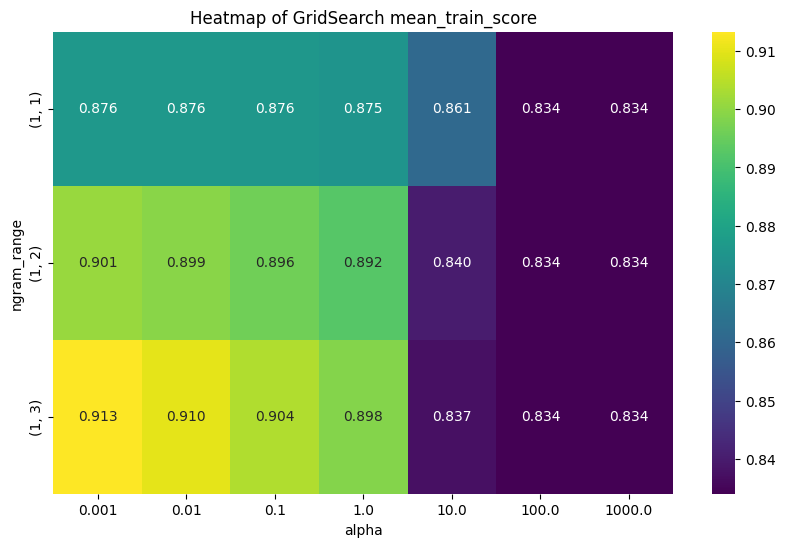

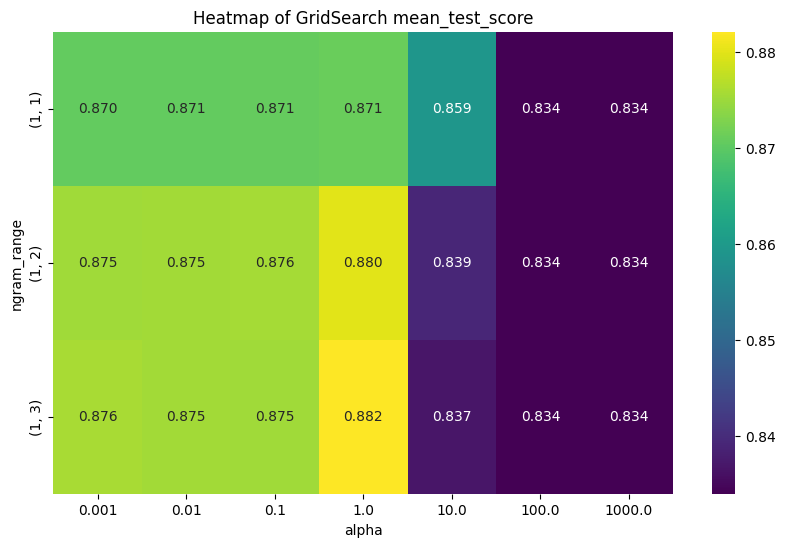

In [ ]:
# Heat maps of mean cross-validation f1 score as a function of the parameters ngram_range and alpha
plot_gridsearch_heatmap(grid_mnb, 
                        x_param='multinomialnb__alpha', 
                        y_param='tfidfvectorizer__ngram_range', score_metric='mean_train_score')

plot_gridsearch_heatmap(grid_mnb,
                        x_param='multinomialnb__alpha', 
                        y_param='tfidfvectorizer__ngram_range', score_metric='mean_test_score')

- Best Performance: Achieved with alpha=1 and ngram_range=(1,3) — including trigrams adds value.
- Stable Across Alphas: (1,1) and (1,2) n-grams perform reliably, especially at lower alpha values.
- Low Alpha Values: Improve learning by reducing smoothing, allowing the model to better capture word patterns.
- High Alpha Values: Degrade performance — too much smoothing leads to loss of important distinctions.
- N-gram Impact: All ranges perform similarly, but (1,3) slightly outperforms others — suggesting trigrams help, but bigrams and unigrams alone may be sufficient.

### **Predicting sentiment and evaluating the model**

In [52]:
y_pred_mnb = grid_mnb.predict(X_test)

#### **Confusion matrix and classification report**

              precision    recall  f1-score   support

           0       0.76      0.55      0.64     43754
           1       0.84      0.93      0.88    109919

    accuracy                           0.82    153673
   macro avg       0.80      0.74      0.76    153673
weighted avg       0.82      0.82      0.81    153673



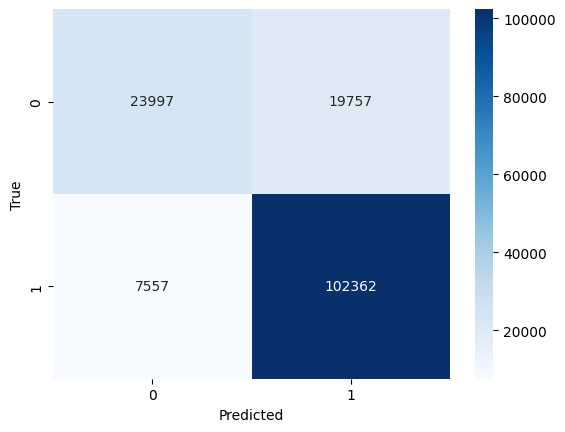

In [53]:
print(classification_report(y_test, y_pred_mnb))

cm = confusion_matrix(y_test, y_pred_mnb)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

**Classification report**: higher precision and recall for positive reviews - likely due to class imbalance - the model better learns patterns from positive reviews.

**Confusion matrix takeaways**
- *High True Positives:* Great at predicting positive reviews.
- *High False Positives:* Likely because the model is biased towards predicting positive sentiment.
- *Low False Negatives:* Few positive reviews were misclassified = good because its not missing many positive reviews.
- *Low True Negatives:* Struggling with correctly identifying negative sentiment - likely because it hasn't learned the patterns of negative reviews as well.

#### **Precision-recall curve evaluation**

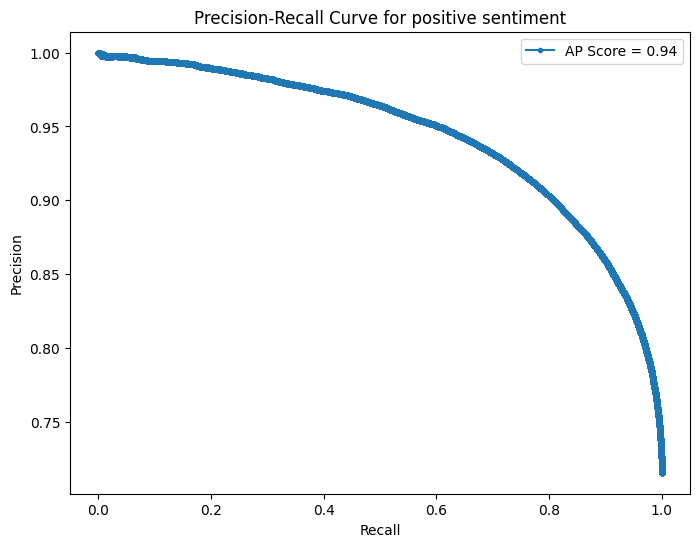

In [ ]:
# Precision-recall curve for majority class
y_scores_pos_mnb = grid_mnb.predict_proba(X_test)[:, 1]
plot_precision_recall_curve(y_test, y_scores_pos_mnb, 'positive')

**PR curve for majority class:**
* Precision remains close to 1.0 for a large portion of the recall range, meaning the model is highly confident when predicting positive reviews.
* Even at high recall, precision only drops slightly, suggesting the model rarely misclassifies non-positive reviews as positive.
* High AP score - suggests the model performs well on the majority class - expected because the model easier these patterns due to class imbalance.

Since the curve is based on the majority class, it is not as informative. Therefore we also look at the minority class:

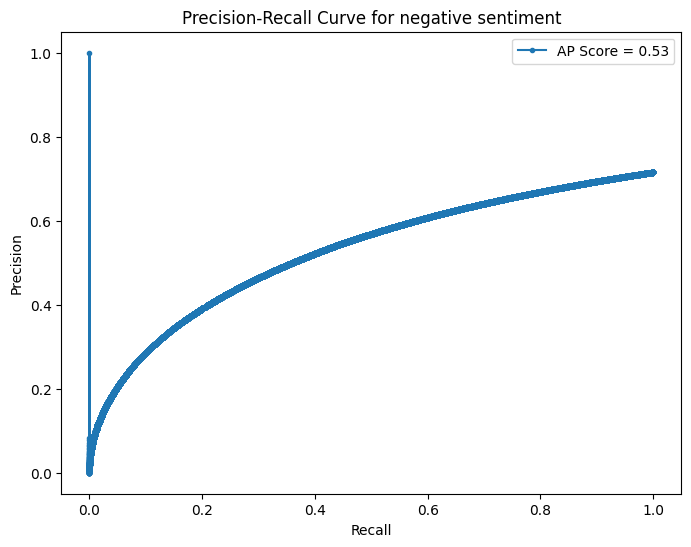

In [ ]:
# Precision-recall curve for minority class
y_scores_neg_mnb = grid_mnb.predict_proba(X_test)[:, 0]
plot_precision_recall_curve(y_test, y_scores_neg_mnb, 'negative')

**PR curve for minority class:**
- AP Score = 0.53: Indicates moderate ability to identify negative reviews — reasonable given the imbalance.
- Initial Sharp Drop: Precision is high when recall is low (model is very selective), but quickly falls as more negative reviews are predicted.
- Precision vs. Recall Tradeoff: As recall increases, precision fluctuates — reflects difficulty in consistently identifying negatives without false positives.
- Recall = 1.0, Precision ≈ 0.8: Model eventually captures all negatives, but precision suffers — typical in imbalanced datasets where the model leans toward the majority (positive) class.

**PR curves summary:** MultinomialMB is excellent at predicting positive reviews but struggles with negatives. Since most reviews are positive, the model may have learned to favor positive predictions, at the expense of recall for negative reviews.

#### **Top features visualization**

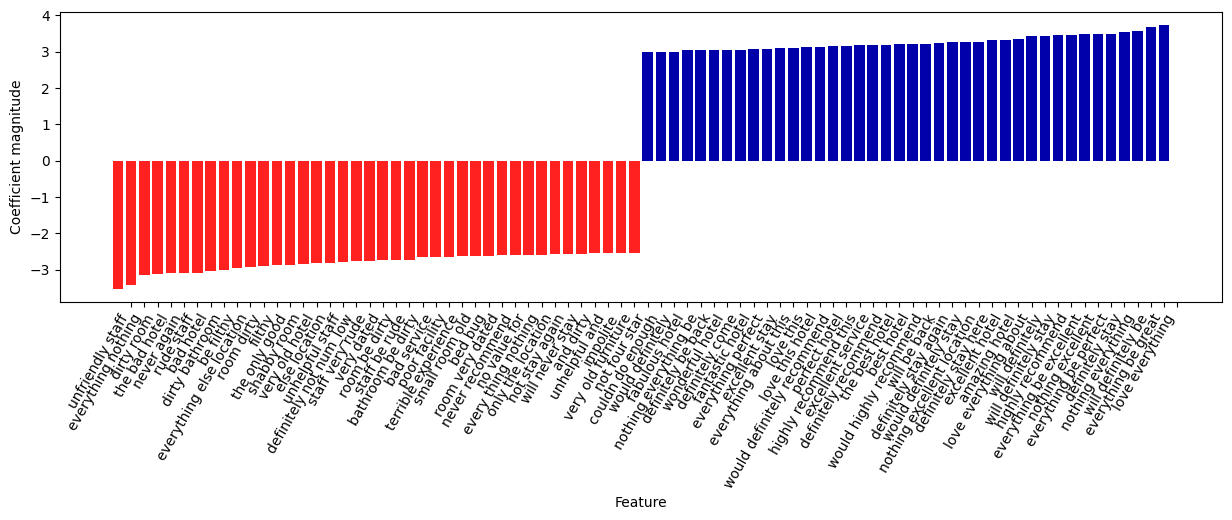

In [ ]:
# Visualizing the top 20 features that are most indicative of positive and negative sentiment of reviews from the best MultinomialNB model.
visualize_top_features(grid_mnb, X_train, classifier_step="multinomialnb")

**Top 20 Domain Features – Takeaways:**
- Positive Indicators: Features with the highest coefficients signal strong association with positive sentiment; lowest coefficients indicate negative sentiment.
- "Nothing" as Positive: The model associates phrases starting with "nothing" (e.g., "nothing excellent") with positive sentiment — likely because such phrases often appear in the Negative_Review field, implying absence of complaints.
- "Everything nothing" as Negative: Though used in positive reviews (e.g., "I liked everything. Nothing to complain about."), the model flags this bigram as negative — likely due to "nothing" usually appearing at the start of positive phrases, and "everything nothing" violating that learned pattern.

## **Complement NB Model**

Chosen because it handles imbalanced data better by adjusting feature weights that are overrepresented in the majority class, making it less biased toward the majority class. We expect improved negative review classification performance over MultinomialNB.

### **Model building**

Same vectorizer and gridsearch params as Multinomial used, as they are suitable for text classification tasks and have been optimized for our dataset. 

In [57]:
if os.path.exists('grid_cnb.pkl'):
    grid_cnb = joblib.load('grid_cnb.pkl')
else:
    pipe_cnb = make_pipeline(TfidfVectorizer(min_df = 5, max_df=0.8, norm='l2'), ComplementNB())
    param_grid = {'complementnb__alpha': [0.001, 0.01, 0.1, 1, 10, 100, 1000], 'tfidfvectorizer__ngram_range': [(1, 1), (1, 2), (1, 3)]}
    kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    grid_cnb = GridSearchCV(pipe_cnb, param_grid, cv=kfold, scoring='f1', refit=True, n_jobs=-1, return_train_score=True)
    grid_cnb.fit(X_train, y_train)

print("Best parameters: {}".format(grid_cnb.best_params_))
print("Best cross-validation score: {:.2f}".format(grid_cnb.best_score_))
print("Best estimator: {}".format(grid_cnb.best_estimator_))

Best parameters: {'complementnb__alpha': 1, 'tfidfvectorizer__ngram_range': (1, 3)}
Best cross-validation score: 0.87
Best estimator: Pipeline(steps=[('tfidfvectorizer',
                 TfidfVectorizer(max_df=0.8, min_df=5, ngram_range=(1, 3))),
                ('complementnb', ComplementNB(alpha=1))])


### **Heatmaps**

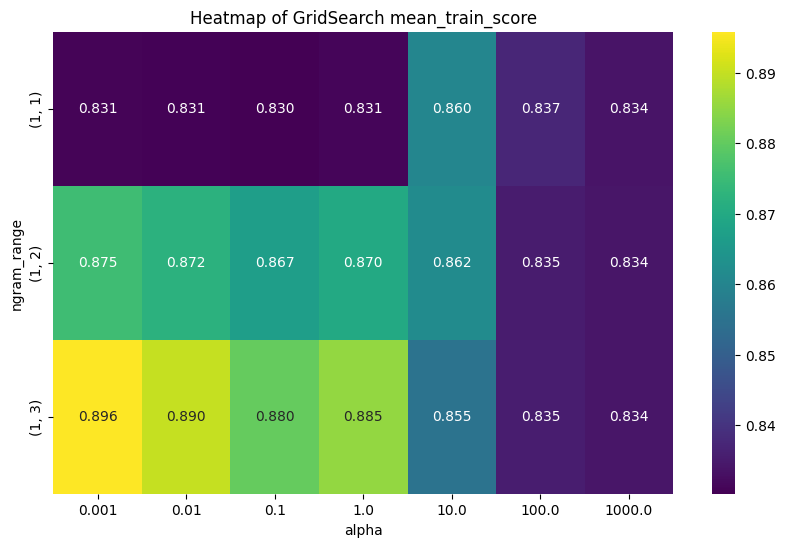

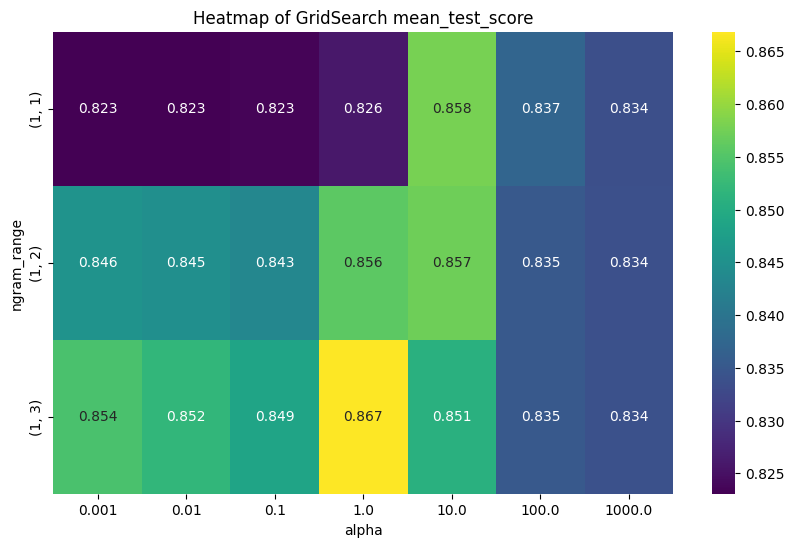

In [ ]:
# Heat maps of mean cross-validation f1 score as a function of the parameters ngram_range and alpha
plot_gridsearch_heatmap(grid_cnb, 
                        x_param='complementnb__alpha', 
                        y_param='tfidfvectorizer__ngram_range', score_metric='mean_train_score')
plot_gridsearch_heatmap(grid_cnb, 
                        x_param='complementnb__alpha', 
                        y_param='tfidfvectorizer__ngram_range', score_metric='mean_test_score')

- Best F1-score achieved with ngram_range=(1,3) and alpha=1, aligning with results from the MultinomialNB model.
- Trigrams help: (1,3) consistently outperforms other ranges across alpha values, suggesting value in capturing context beyond single or paired words.
- Unigrams underperform: (1,1) lags behind (1,2) and (1,3) for alpha values between 0.001–1, indicating that relying on single words and low smoothing leads to underfitting.

### **Predicting sentiment and evaluating the model**

In [59]:
y_pred_cnb = grid_cnb.predict(X_test)

#### **Confusion matrix and classification report**

              precision    recall  f1-score   support

           0       0.65      0.72      0.68     43754
           1       0.88      0.85      0.87    109919

    accuracy                           0.81    153673
   macro avg       0.77      0.78      0.78    153673
weighted avg       0.82      0.81      0.81    153673



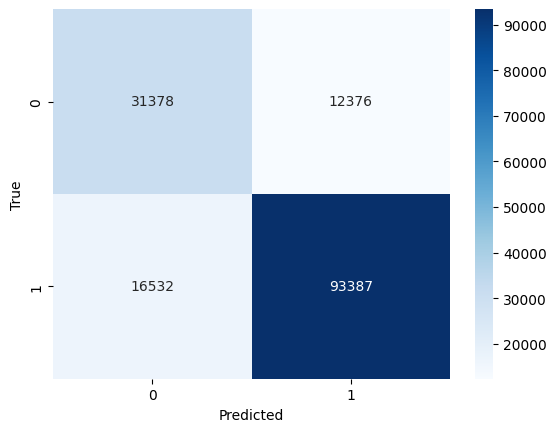

In [60]:
print(classification_report(y_test, y_pred_cnb))

cm = confusion_matrix(y_test, y_pred_cnb)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')

plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

**Confusion matrix takeaways:**
* *High True Positives:* Great at predicting positive reviews - expected due to class imbalance.    
* *More False Negatives Than False Positives:* Distribution of FP and FN is more balanced than in MultinomialNB, indicating ComplementNB is not as conservative in predicting negative.
* *Low True Negatives:* Struggles with correctly identifying negative sentiment, but the number of TN is higher than in MultinomialNB, suggesting ComplementNB has learned the patterns of negative reviews better.

#### **Precision-recall curve evaluation**

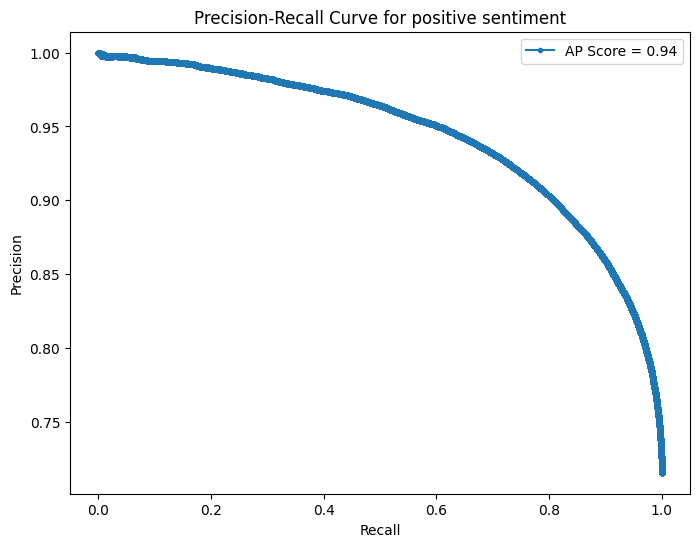

In [ ]:
# Precision-recall curve for the majority class, i.e. positive sentiment
y_scores_pos_cnb = grid_cnb.predict_proba(X_test)[:, 1]
plot_precision_recall_curve(y_test, y_scores_pos_cnb, 'positive')

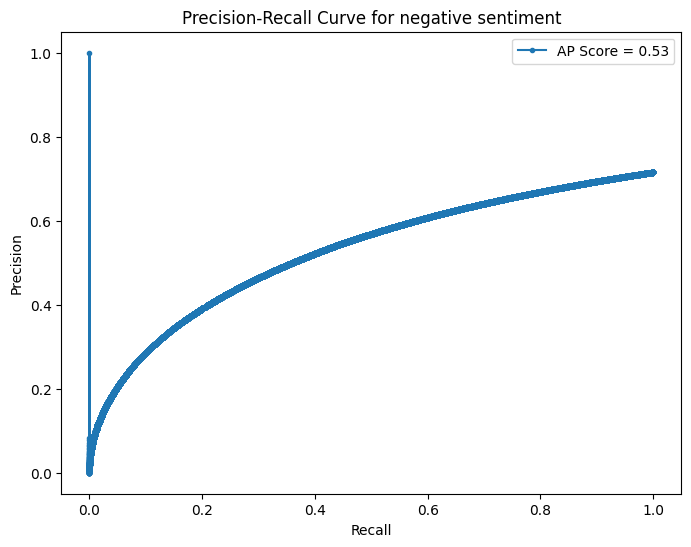

In [ ]:
# Precision-recall curve for the minority class, i.e. negative sentiment
y_scores_neg_cnb = grid_cnb.predict_proba(X_test)[:, 0]
plot_precision_recall_curve(y_test, y_scores_neg_cnb, 'negative')

PR-curves for positive and negative sentiment are identical to those from MultinomialNB. This is interesting, as their confusion matrices differ slightly.
To investigate this further, we plot a histogram of predicted probabilities.

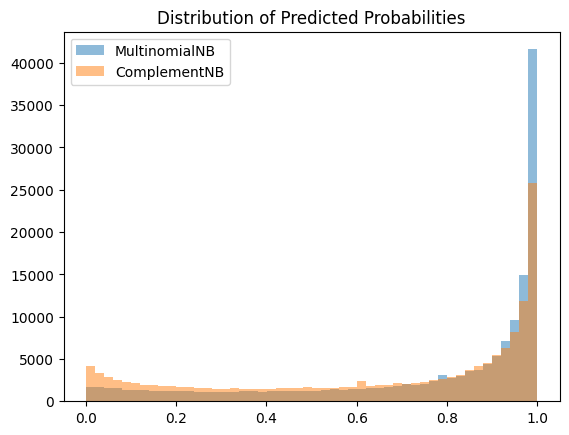

In [ ]:
plt.hist(y_scores_pos_mnb, bins=50, alpha=0.5, label='MultinomialNB')
plt.hist(y_scores_pos_cnb, bins=50, alpha=0.5, label='ComplementNB')
plt.legend()
plt.title("Distribution of Predicted Probabilities")
plt.show()

**Result**
* Similar shape of distributed prediction probabilities.
* Both MultinomialNB and ComplementNB are confident in their predictions, but ComplementNB catches more negative sentiment and less positive sentiment than MultinomialNB.
* Distribution curve: suggests it is not strange that their PR-Curves are the same, e.g. they are almost equally confident in classifying sentiment, rather, they just catch different amounts of each class, which is expected. 

#### **Top features visualization**

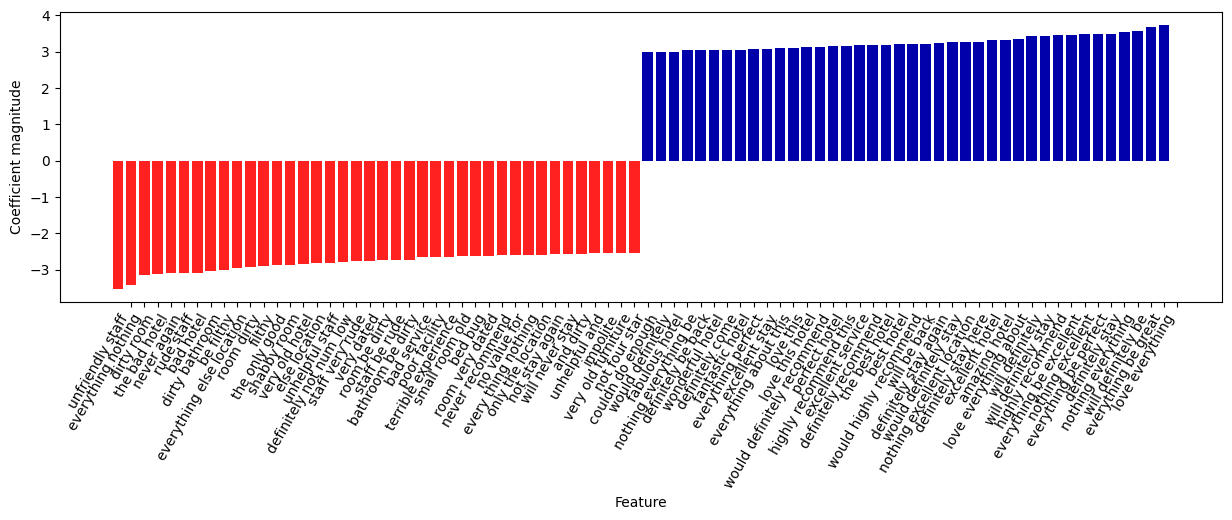

In [ ]:
# Visualizing the top 20 features that are most indicative of positive and negative sentiment of reviews from the best ComplementNB model.
visualize_top_features(grid_cnb, X_train, classifier_step="complementnb")

Many of the same word combinations as in MultinomialNB appear - not surprising, as the models perform very similar.

### **Comparing Multinomial NB & Complement NB**

**Main differences:**
* Despite being based off the same algorithm, ComplementNB is better at classifying negative sentiment - not surprising as ComplementNB usually is better for imbalanced datasets.
* Performance for positive sentiment: relatively similar, with ComplementNBs performance dipping a bit, to account for increased negative sentiment classification performance.

**Conclusion:** 
* ComplementNB is more balanced in its ability to detect sentiment, thus being more suited for our task.

## **Light Gradient Boosting Machine Classifier**


**Chosen because it can handle:**
* Large datasets and high-dimentional data faster than XGBoost. 
* Class imbalance - the parameter "is_unbalance" adjusts the weights of the classes based on their frequency in the dataset.

RandomizedSearch used instead of GridSearch because: less computationally expensive and time consuming. 

### **Creating Pipeline, Vectorizer and RandomizedSearch with cross validation**

In [65]:
if os.path.exists('rand.pkl'):
    rand = joblib.load('rand.pkl')
else:
    pipe_lgbm = make_pipeline(
        TfidfVectorizer(min_df=5, max_df=0.8, norm='l2'),
        LGBMClassifier(is_unbalance=True, random_state=42)
    )
    param_dist = {
        'lgbmclassifier__num_leaves': [31, 63, 127],  
        'lgbmclassifier__max_depth': [5, 7, 10], 
        'lgbmclassifier__learning_rate': [0.01, 0.05, 0.1],
        'lgbmclassifier__n_estimators': [100, 300, 500],
        'lgbmclassifier__subsample': [0.8, 1.0],
        'lgbmclassifier__colsample_bytree': [0.8, 1.0]
    }
    kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    rand = RandomizedSearchCV(
        pipe_lgbm,
        param_distributions=param_dist,
        cv=kfold,
        scoring='f1',
        refit=True,
        n_iter=20,
        verbose=2,
        n_jobs=2,
        error_score='raise'
    )
    rand.fit(X_train, y_train)

print("Best parameters: {}".format(rand.best_params_))
print("Best cross-validation score: {:.2f}".format(rand.best_score_))
print("Best estimator: {}".format(rand.best_estimator_))

Best parameters: {'lgbmclassifier__subsample': 1.0, 'lgbmclassifier__num_leaves': 63, 'lgbmclassifier__n_estimators': 100, 'lgbmclassifier__max_depth': 10, 'lgbmclassifier__learning_rate': 0.01, 'lgbmclassifier__colsample_bytree': 0.8}
Best cross-validation score: 0.85
Best estimator: Pipeline(steps=[('tfidfvectorizer', TfidfVectorizer(max_df=0.8, min_df=5)),
                ('lgbmclassifier',
                 LGBMClassifier(colsample_bytree=0.8, is_unbalance=True,
                                learning_rate=0.01, max_depth=10, num_leaves=63,
                                random_state=42))])


### **Predicting sentiment and evaluating the model**

In [66]:
y_pred_lgbm = rand.predict(X_test)

c:\Users\runar\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


#### **Confusion matrix and classification report**

              precision    recall  f1-score   support

           0       0.63      0.47      0.54     43754
           1       0.81      0.89      0.85    109919

    accuracy                           0.77    153673
   macro avg       0.72      0.68      0.69    153673
weighted avg       0.76      0.77      0.76    153673



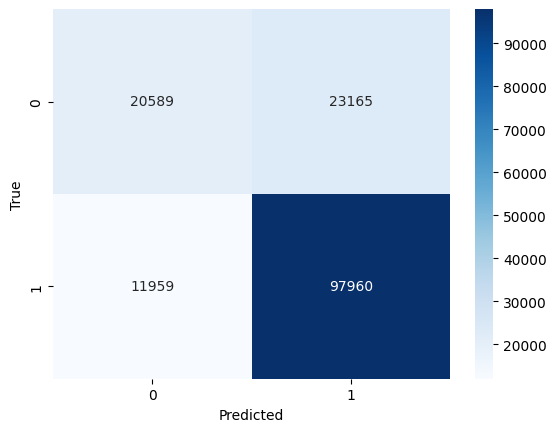

In [67]:
print(classification_report(y_test, y_pred_lgbm))
cm = confusion_matrix(y_test, y_pred_lgbm)

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

**Performance takeaways:**
* Low f1-score for negative sentiment: 0.54 - struggles to identify negative sentiment.
* High TP and f1-score for positive sentiment: great at predicting positive reviews.
* More FP than TN: biased towards predicting positive sentiment - has not learned negative review patterns well. 

#### **Precision-recall curve evaluation**

c:\Users\runar\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


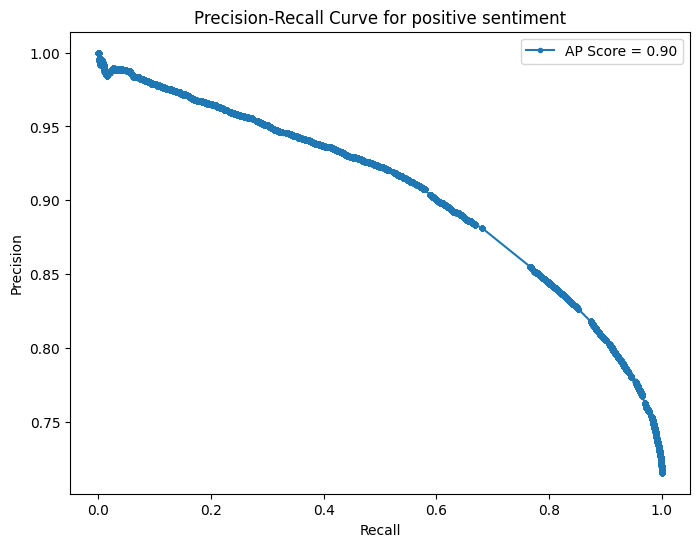

c:\Users\runar\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


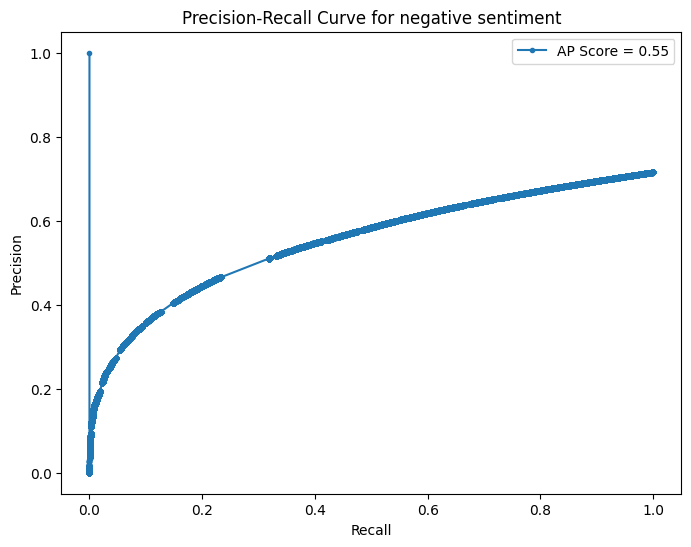

In [ ]:
# Precision-recall for the majority class, i.e. positive sentiment
y_scores_pos_lgbm = rand.predict_proba(X_test)[:, 1]
plot_precision_recall_curve(y_test, y_scores_pos_lgbm, 'positive')

# Precision-recall for the minority class, i.e. negative sentiment
y_scores_neg_lgbm = rand.predict_proba(X_test)[:, 0]
plot_precision_recall_curve(y_test, y_scores_neg_lgbm, 'negative')

**PR curves takeaways:**
* Similar curve shape and approximately same AP scores as Naive Bayes models 
* Sparse curve: less smooth than NB models - typical for tree-based models - they group data into leaves, giving many samples the same prediction score, which results in fewer points on the curve = more stepped curve.

#### **Vizualising important features**

C:\Users\runar\AppData\Local\Temp\ipykernel_8512\2637428754.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='importance', y='features', data=fi_sorted, palette='viridis')


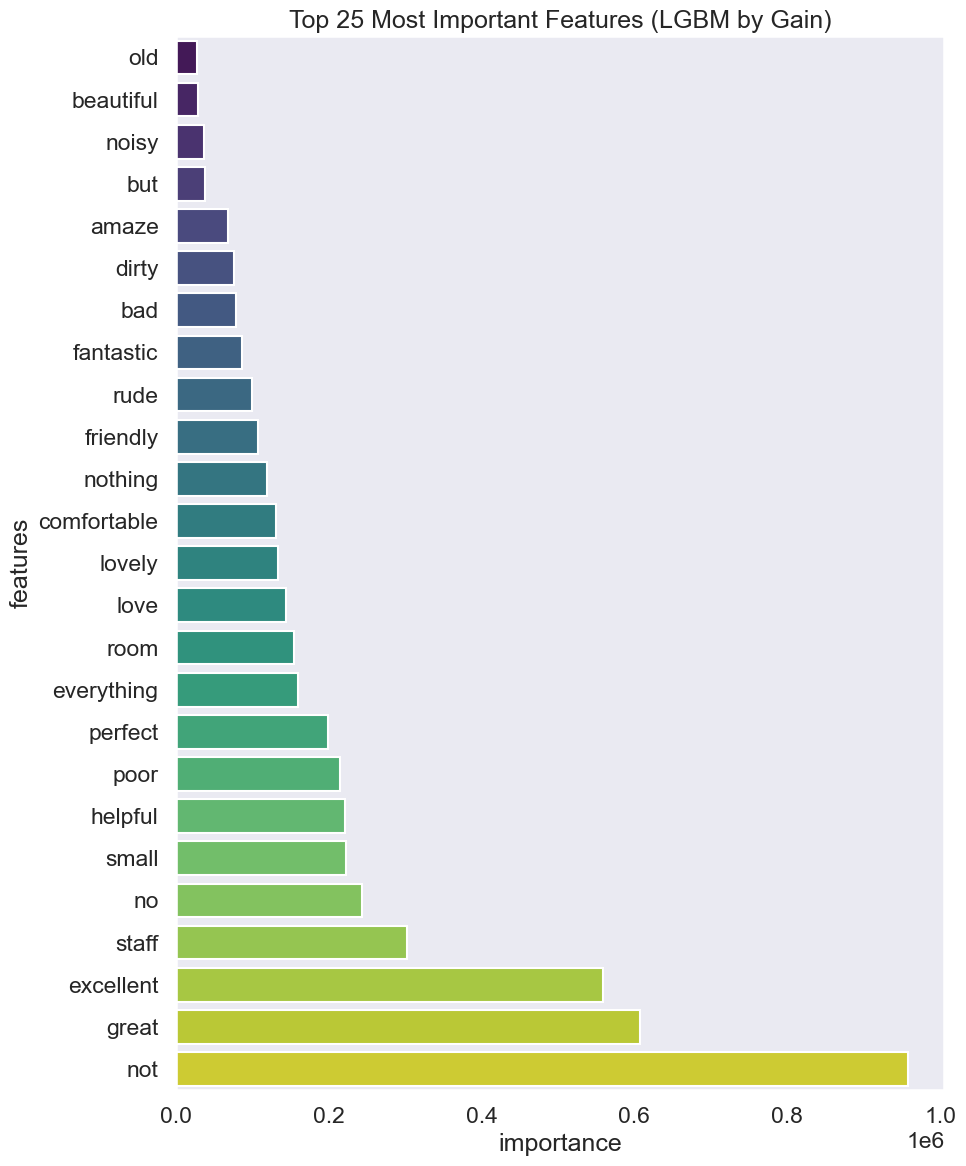

In [69]:
# Extract fitted vectorizer and model
vectorizer = rand.best_estimator_.named_steps['tfidfvectorizer']
lgbm_tuned = rand.best_estimator_.named_steps['lgbmclassifier']

# Get feature names and importances
feature_names = vectorizer.get_feature_names_out()
importances = lgbm_tuned.booster_.feature_importance(importance_type='gain')

# Create DataFrame for feature importances
fi = pd.DataFrame({
    'features': feature_names,
    'importance': importances
})

# Sort and plot
fi_sorted = fi.sort_values(by='importance', ascending=True).tail(25)  # plot top 25 for clarity

sns.set_context("talk")
sns.set_style('dark')

plt.figure(figsize=(10, 12))
sns.barplot(x='importance', y='features', data=fi_sorted, palette='viridis')
plt.title('Top 25 Most Important Features (LGBM by Gain)')
plt.tight_layout()
plt.show()

**Takeaways:**
- “Not” is the most influential word — makes sense as a common negation that can flip sentiment in either direction.
- The model picks up both opinion words (e.g., great, poor) and contextual words (e.g., staff, room, comfortable), showing it captures both emotion and topic relevance.

## **LSTM Model**

### **Preprocessing data for LSTM**

#### **Splitting the dataset into training, validation and test sets**

In [ ]:
print(len(X)) 
print(len(y)) 

512243
512243


In [ ]:
# Splitting the data into 60% training, 20% validation, and 20% test sets all with class balance maintained
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

X_temp = X_temp.to_numpy()
y_temp = y_temp.to_numpy()

X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=0.25, random_state=42, stratify=y_temp  
)

#### **Tokenizing and padding - preparing reviews for LSTM**

**Tokenizer settings explanation:**
- num_words=5000: Limits the tokenizer to the top 5,000 most frequent words — reduces vocabulary size and improves model efficiency.
- texts_to_sequences: Converts each review into a sequence of integers, mapping each word to its corresponding index in the vocabulary.

In [72]:
tokenizer = Tokenizer(num_words=5000, oov_token="<OOV>")
tokenizer.fit_on_texts(X_train)

X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)
X_val_seq = tokenizer.texts_to_sequences(X_val)

In [73]:
max_length_train = max([len(review) for review in X_train_seq])
max_length_test = max([len(review) for review in X_test_seq])
max_length_val = max([len(review) for review in X_val_seq])
max_length = max(max_length_train, max_length_test, max_length_val)
print(max_length)

763


As we can see, the model will receive inputs that all have a consistent size of 763 tokens.

To better understand how many reviews are really long and how many are short we plot a histogram of the review lengths.

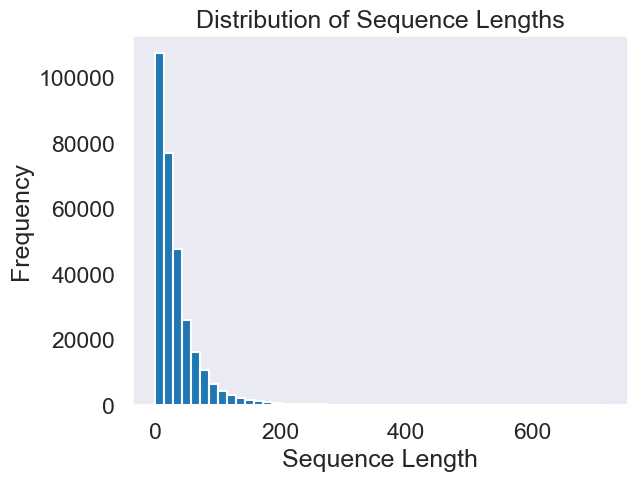

In [74]:
seq_lengths = [len(review) for review in X_train_seq]
plt.hist(seq_lengths, bins=50)
plt.xlabel('Sequence Length')
plt.ylabel('Frequency')
plt.title('Distribution of Sequence Lengths')
plt.show()

In [75]:
print(pd.Series(seq_lengths).describe())

count    307345.000000
mean         34.008473
std          39.057640
min           0.000000
25%          11.000000
50%          22.000000
75%          43.000000
max         718.000000
dtype: float64


**Sequence Length Takeaway:**

- Max length of 753 is unnecessary — 75% of reviews are under 43 tokens, and the histogram shows little added value beyond 150 tokens.
- New max length: 150 — balances efficiency and information retention, avoiding excessive padding.
- Padding/truncation ensures fixed-length inputs, which is required for LSTM models to function properly.

In [76]:
max_length = 150

X_train_padded = pad_sequences(X_train_seq, maxlen=max_length, padding='post', truncating='post')
X_test_padded = pad_sequences(X_test_seq, maxlen=max_length, padding='post', truncating='post')
X_val_padded = pad_sequences(X_val_seq, maxlen=max_length, padding='post', truncating='post')

In [77]:
print("X_train_padded:")
print(X_train_padded)
print("\nX_test_padded:")
print(X_test_padded)
print("\nX_val_padded:")
print(X_val_padded)

X_train_padded:
[[   2  593   11 ...    0    0    0]
 [  22  160  470 ...    0    0    0]
 [  22  139  637 ...    0    0    0]
 ...
 [  16   75    5 ...    0    0    0]
 [  78  593    3 ...    0    0    0]
 [ 133    2 2186 ...    0    0    0]]

X_test_padded:
[[   2  147  335 ...    0    0    0]
 [  20 1493   23 ...    0    0    0]
 [  71  758    3 ...    0    0    0]
 ...
 [   2   12   10 ...    0    0    0]
 [ 463   31    2 ...    0    0    0]
 [  35  545   23 ...    0    0    0]]

X_val_padded:
[[  21   89 1460 ...    0    0    0]
 [  14   12   16 ...    0    0    0]
 [ 147  335    6 ...    0    0    0]
 ...
 [ 106  124   14 ...    0    0    0]
 [  41    3   35 ...    0    0    0]
 [   7    3  148 ...    0    0    0]]


### **Building the LSTM model**

**Model Architecture & Training Setup:**
- Sequential Model:
    - Builds the model in a linear stack, layer by layer.
- Embedding Layer:
    - input_dim=5000: Number of unique words in the vocabulary, as defined by the tokenizer.
    - output_dim=128: Each word is represented as a 128-dim dense vector.
    - input_length=max_length: Input sequences are padded/truncated to a fixed length.
- Bidirectional LSTM Layer:
    - units=128: Size of LSTM hidden state.
    - dropout=0.3: Regularization to prevent overfitting.
    - return_sequences=False: Outputs only final state, not full sequence.
    - Allows the model to learn context from both directions in the text.
- Fully Connected Dense Layers:
    - Dense(128, activation='relu')
        - Learns abstract features from LSTM output.
        - Followed by BatchNormalization() to stabilize and speed up training.
        - Followed by Dropout(0.3) to improve generalization.
    - Dense(64, activation='relu')
        - Further compresses features.
        - Followed by another Dropout(0.3) layer.
- Output Layer:
        - Dense(1, activation='sigmoid'): Final prediction: Outputs a probability between 0 and 1 for binary classification.
- Compilation:
        - Loss: BinaryFocalCrossentropy(alpha=0.25, gamma=2.0) — focuses training on hard-to-classify examples, good for imbalanced datasets.
        - Optimizer: 'adam' — efficient and adaptive.
        - Metrics:
            - 'accuracy': Proportion of correct predictions.
            - AUC(curve='PR'): Precision-Recall AUC — more informative under class imbalance.
- Callbacks:
    - EarlyStopping: Stops training if validation loss doesn’t improve for 3 epochs.
    - ReduceLROnPlateau: Lowers learning rate if val loss stagnates, helping the model converge smoothly.

- Build:
    - input_shape=(None, max_length): Sets the expected input shape for the model.

In [ ]:
model = Sequential()

model.add(Embedding(input_dim=5000, output_dim=128, input_length=max_length))

model.add(Bidirectional(LSTM(units=128, dropout=0.3,  return_sequences=False)))

model.add(Dense(128, activation="relu"))
model.add(BatchNormalization())
model.add(Dropout(0.3))

model.add(Dense(64, activation="relu"))
model.add(Dropout(0.3))

model.add(Dense(1, activation='sigmoid'))

model.compile(loss=keras.losses.BinaryFocalCrossentropy(alpha=0.25, gamma=2.0), optimizer='adam', metrics=['accuracy', tf.keras.metrics.AUC(curve='PR')])

early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
reduce_learning_rate = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=1, min_lr=0.00001)

model.build(input_shape=(None, max_length))

model.summary()

c:\Users\runar\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_3 (Embedding)         │ (None, 150, 128)       │       640,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_6 (Bidirectional) │ (None, 256)            │       263,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 944,897 (3.60 MB)

 Trainable params: 944,641 (3.60 MB)

 Non-trainable params: 256 (1.00 KB)

### **Training the LSTM model**

In [84]:
class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)
class_weights_dict = dict(enumerate(class_weights))

history = model.fit(X_train_padded, y_train, epochs=10, batch_size=256, validation_data=(X_val_padded, y_val), callbacks=[early_stopping, reduce_learning_rate], class_weight=class_weights_dict)

Epoch 1/10
1201/1201 ━━━━━━━━━━━━━━━━━━━━ 920s 762ms/step - accuracy: 0.7281 - auc_1: 0.9161 - loss: 0.1320 - val_accuracy: 0.7584 - val_auc_1: 0.9464 - val_loss: 0.1200 - learning_rate: 0.0010
Epoch 2/10
1201/1201 ━━━━━━━━━━━━━━━━━━━━ 873s 727ms/step - accuracy: 0.7937 - auc_1: 0.9471 - loss: 0.1114 - val_accuracy: 0.7987 - val_auc_1: 0.9507 - val_loss: 0.1066 - learning_rate: 0.0010
Epoch 3/10
1201/1201 ━━━━━━━━━━━━━━━━━━━━ 856s 713ms/step - accuracy: 0.8045 - auc_1: 0.9530 - loss: 0.1062 - val_accuracy: 0.8242 - val_auc_1: 0.9512 - val_loss: 0.0992 - learning_rate: 0.0010
Epoch 4/10
1201/1201 ━━━━━━━━━━━━━━━━━━━━ 847s 705ms/step - accuracy: 0.8110 - auc_1: 0.9559 - loss: 0.1030 - val_accuracy: 0.8033 - val_auc_1: 0.9516 - val_loss: 0.1069 - learning_rate: 0.0010
Epoch 5/10
1201/1201 ━━━━━━━━━━━━━━━━━━━━ 831s 692ms/step - accuracy: 0.8214 - auc_1: 0.9611 - loss: 0.0978 - val_accuracy: 0.8005 - val_auc_1: 0.9524 - val_loss: 0.1114 - learning_rate: 2.0000e-04
Epoch 6/10
1201/1201 ━━━━━

### **Predicting sentiment**

In [ ]:
y_pred = model.predict(X_test_padded)

3202/3202 ━━━━━━━━━━━━━━━━━━━━ 111s 35ms/step


### **Evaluating LSTM model and plotting accuracy and loss**

3202/3202 ━━━━━━━━━━━━━━━━━━━━ 117s 36ms/step
0.8920616108977033
0.9511967375559408
3202/3202 ━━━━━━━━━━━━━━━━━━━━ 121s 38ms/step - accuracy: 0.8224 - auc_1: 0.9511 - loss: 0.0991
Test accuracy: 0.8215990662574768
Test loss: 0.09955291450023651


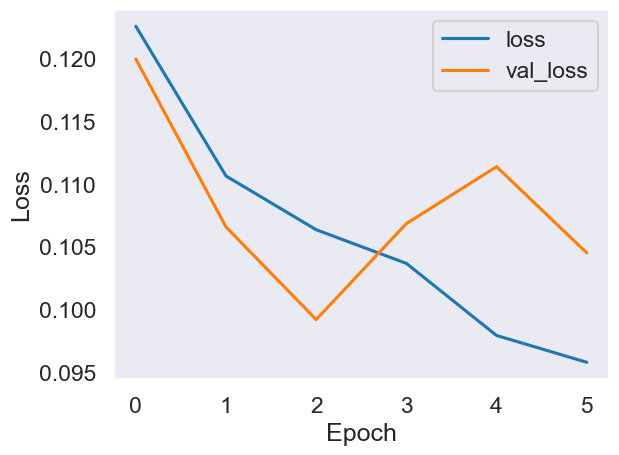

In [ ]:
X_test_padded_np = np.array(X_test_padded)
y_test_np = np.array(y_test)

y_pred_probs = model.predict(X_val_padded)
print(roc_auc_score(y_val, y_pred_probs))
print(average_precision_score(y_val, y_pred_probs))

# test the model
loss, accuracy, _ = model.evaluate(X_test_padded_np, y_test_np)
print('Test accuracy:', accuracy)
print('Test loss:', loss)

# plot the training and validation loss
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label = 'val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.show()

**Graph insights**:
- Training loss decreases steadily as expected, indicating the model is learning.
- Validation loss reaches its minimum at epoch 2, then begins to increase - sign of overfitting.
- Overall: loss values remain low and are trending downwards, and the level of overfitting observed is minor and acceptable at this stage.

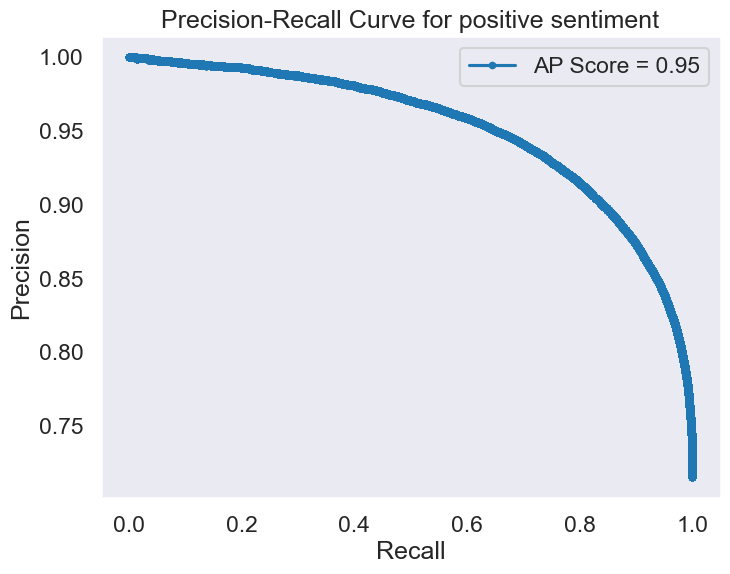

In [ ]:
plot_precision_recall_curve(y_val, y_pred_probs, 'positive')

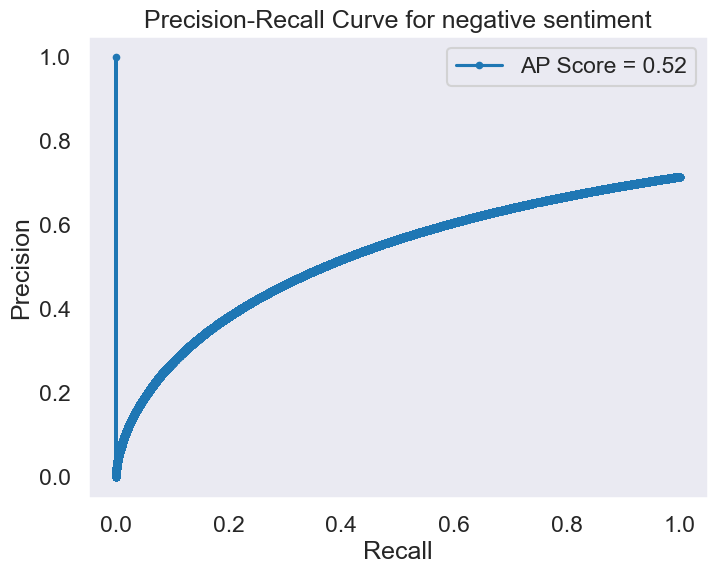

In [98]:
y_probs_negative = 1 - y_pred_probs
plot_precision_recall_curve(y_val, y_probs_negative, 'negative')

PR-Curves are almost identical to previous models. Slight difference, but not significant.

Predictions:
              precision    recall  f1-score   support

           0       0.67      0.75      0.70     29169
           1       0.89      0.85      0.87     73280

    accuracy                           0.82    102449
   macro avg       0.78      0.80      0.79    102449
weighted avg       0.83      0.82      0.82    102449



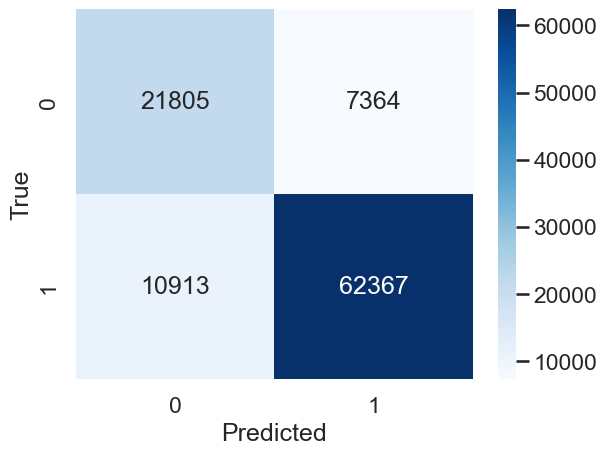

In [94]:
y_pred_binary = (y_pred > 0.5).astype(int)
print("Predictions:")
print(classification_report(y_test, y_pred_binary))

cm = confusion_matrix(y_test, y_pred_binary)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

- High True Positives 
- Relatively high True Negatives 
- Low instances of False Positives and False Negatives